In [1]:
# import all functions
from functions import *
import matplotlib.pyplot as plt
import numpy as np

## Test sphere quantify

In [104]:
import py3Dmol
import numpy as np
from scipy.spatial import ConvexHull

def filter_pt_atoms(dic):
    return dic[:,0:3][np.where(dic[:,3]==1)]

def calculate_sphericity(points):
    # Calculate the convex hull
    hull = ConvexHull(points)

    # Volume (V) and surface area (A) of the convex hull
    V = hull.volume
    A = hull.area

    # Calculate the sphericity
    sphericity = (np.pi ** (1/3)) * ((6 * V) ** (2/3)) / A
    return sphericity

def plot_convex_hull(points):
    view = py3Dmol.view(width=800, height=400)

    # Add points to the viewer
    for point in points:
        view.addSphere({'center': {'x': point[0], 'y': point[1], 'z': point[2]}, 
                        'radius': 0.5, 'color': 'red'})

    # Calculate the convex hull
    hull = ConvexHull(points)

    # Add edges of the convex hull
    for simplex in hull.simplices:
        for i in range(len(simplex)):
            start = simplex[i]
            end = simplex[(i + 1) % len(simplex)]  # Wrap around with modulo
            start_point = points[start]
            end_point = points[end]
            view.addCylinder({'start': {'x': start_point[0], 'y': start_point[1], 'z': start_point[2]},
                              'end': {'x': end_point[0], 'y': end_point[1], 'z': end_point[2]},
                              'radius': 0.1, 'color': 'blue', 'fromCap': 0, 'toCap': 0})

    view.zoomTo()
    return view


In [174]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

def count_surface_pt_atoms(array, neighbor_cutoff=3.1):
    # Isolate atoms of each type and their indices
    indices_pt = np.where(array[:, 3] == 1)[0]  # Pt atoms
    atoms_pt = array[indices_pt, :3]

    # Calculate neighbor counts for Pt atoms
    distances_pt_pt = cdist(atoms_pt, atoms_pt)
    neighbor_counts = np.sum(distances_pt_pt < neighbor_cutoff, axis=1) - 1  # exclude self-counting

    # Count Pt atoms with fewer than 9 neighbors
    low_neighbor_count = np.sum(neighbor_counts <=9 )

    return low_neighbor_count

def average_surface_pt(dic):
    data = dic["data"]
    c_array = []
    for d in data:
        c = count_surface_pt_atoms(d)
        c_array.append(c)
    c_array = np.array(c_array)
    c_array = np.mean(c_array)

    return c_array


In [175]:
average_surface_pt(benchmark147["data"])

TypeError: list indices must be integers or slices, not str

## benchmark code on ideal shapes

In [2]:
benchmark147 = {}
benchmark147["data"] = [read_xyz("./test_models/modified_particle.xyz")]*10

benchmark309 = {}
benchmark309["data"] = [read_xyz("./test_models/modified_particle_309.xyz")]*10

benchmark561 = {}
benchmark561["data"] = [read_xyz("./test_models/modified_particle_561.xyz")]*10

benchmark147_ico = {}
benchmark147_ico["data"] = [read_xyz("./test_models/modified_particle_ico_147.xyz")]*10

benchmark309_ico = {}
benchmark309_ico["data"] = [read_xyz("./test_models/modified_particle_ico_309.xyz")]*10

benchmark561_ico = {}
benchmark561_ico["data"] = [read_xyz("./test_models/modified_particle_ico_561.xyz")]*10

bm_WC_147, bm_UC_147, _ , _ , _ , _ = bond_lengths_WCUCMC(benchmark147)
bm_WC_309, bm_UC_309, _ , _ , _ , _ = bond_lengths_WCUCMC(benchmark309)
bm_WC_561, bm_UC_561, _ , _ , _ , _ = bond_lengths_WCUCMC(benchmark561)

bm_WC_147_ico, bm_UC_147_ico, _ , _ , _ , _ = bond_lengths_WCUCMC(benchmark147_ico)
bm_WC_309_ico, bm_UC_309_ico, _ , _ , _ , _ = bond_lengths_WCUCMC(benchmark309_ico)
bm_WC_561_ico, bm_UC_561_ico, _ , _ , _ , _ = bond_lengths_WCUCMC(benchmark561_ico)

f_WC_147 = bm_WC_147 / (bm_WC_147 + bm_UC_147)
f_UC_147 = bm_UC_147 / (bm_WC_147 + bm_UC_147)

f_WC_309 = bm_WC_309 / (bm_WC_309 + bm_UC_309)
f_UC_309 = bm_UC_309 / (bm_WC_309 + bm_UC_309)

f_WC_561 = bm_WC_561 / (bm_WC_561 + bm_UC_561)
f_UC_561 = bm_UC_561 / (bm_WC_561 + bm_UC_561)

f_WC_147_ico = bm_WC_147_ico / (bm_WC_147_ico + bm_UC_147_ico)
f_UC_147_ico = bm_UC_147_ico / (bm_WC_147_ico + bm_UC_147_ico)

f_WC_309_ico = bm_WC_309_ico / (bm_WC_309_ico + bm_UC_309_ico)
f_UC_309_ico = bm_UC_309_ico / (bm_WC_309_ico + bm_UC_309_ico)

f_WC_561_ico = bm_WC_561_ico / (bm_WC_561_ico + bm_UC_561_ico)
f_UC_561_ico = bm_UC_561_ico / (bm_WC_561_ico + bm_UC_561_ico)

print(f"Ideal CUBO Shapes \n Fractions \n 147 | WC: {f_WC_147} | UC: {f_UC_147} \n 309 | WC: {f_WC_309} | UC: {f_UC_309} \n 561 | WC: {f_WC_561} | UC: {f_UC_561} \n")
print(f"Ideal ICO Shapes \n Fractions \n 147 | WC: {f_WC_147_ico} | UC: {f_UC_147_ico} \n 309 | WC: {f_WC_309_ico} | UC: {f_UC_309_ico} \n 561 | WC: {f_WC_561_ico} | UC: {f_UC_561_ico} \n")

Ideal CUBO Shapes 
 Fractions 
 147 | WC: 0.34782608695652173 | UC: 0.6521739130434783 
 309 | WC: 0.48148148148148145 | UC: 0.5185185185185185 
 561 | WC: 0.5714285714285714 | UC: 0.42857142857142855 

Ideal ICO Shapes 
 Fractions 
 147 | WC: 0.8695652173913043 | UC: 0.13043478260869565 
 309 | WC: 0.9259259259259259 | UC: 0.07407407407407407 
 561 | WC: 0.9523809523809523 | UC: 0.047619047619047616 



/home/nickj/miniconda3/envs/OVITO/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nickj/miniconda3/envs/OVITO/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [80]:
benchmark_sphericity = {}
benchmark_sphericity[147] = calculate_sphericity(filter_pt_atoms(benchmark147["data"][0]))
benchmark_sphericity[309] = calculate_sphericity(filter_pt_atoms(benchmark309["data"][0]))
benchmark_sphericity[561] = calculate_sphericity(filter_pt_atoms(benchmark561["data"][0]))

## 147

In [8]:
# create the data dictionary
# edit paths

cluster_dict_147 = {}
#for i in ["148", "298", "398", "498", "623"]:
for i in ["148K_3","173K_6", "198K_6", "223K_6", "273K_6", "298K_6", "398K_6", "498K_6", "623K_6"]:

    ###########################################

    traj_dir = '/mnt/a/MD_Trajectories/PtCO/NPs/continued/cubo_147/'
    traj_name = f"Pt147_cuboct_{i}.all.bin"

    #p_name = "Pt309_cuboct_498K"
    #input_dir = "/mnt/a/MD_Trajectories/PtCO/NPs/Inputs/"
    #input_dir = "/mnt/sdcc/sdcc+u/nmarcella/MD_EXAFS_inputs/231228/"

    #pipeline.source.num_frames
    ###########################################
    
    traj_path = traj_dir + traj_name

    pipeline = import_file(traj_path)
    # shift particle away from PBC edges. -- key to getting things to work.
    tm = [[1, 0, 0, -100],
                [0,  1, 0,200],
                [0, 0, 1, -100]]

    pipeline.modifiers.append(AffineTransformationModifier(operate_on = {'cell'}, transformation=tm))
    pipeline.modifiers.append(WrapPeriodicImagesModifier())

    test_pl = MD_EXAFS_Analysis_Pipeline_PtCO(pipeline, file_params={"framerange": range(0,pipeline.source.num_frames,100),"atoms":{"Pt":1, "C":2, "O":3}, "cutoff":3}, custom_analysis_func=find_adsorbed_CO)
    #test_pl = MD_EXAFS_Binary_Pipeline_General(pipeline, file_params={"framerange": range(15999,16000),"atoms":{"Pt":1}, "cutoff":3})
    test_pl.run()

    data = test_pl.data
    n_atoms = test_pl.n_atoms_list

    n_atoms = np.array(n_atoms)
    n_co = np.mean(n_atoms[:,1])

    cluster_dict_147[i] = {"CO" :n_atoms[:,1], "data":data}

In [46]:
sphere_dict = {}

In [66]:
# Example usage

sphere_list_mean = []
sphere_list_std = []
for i in ["148K_3","173K_6", "198K_6", "223K_6", "273K_6", "298K_6", "398K_6", "498K_6", "623K_6"]:
    sphere_list_i = []
    for data in cluster_dict_147[i]["data"]:
        points = filter_pt_atoms(data)
        sphericity = calculate_sphericity(points)
        sphere_list_i.append(sphericity)
    sphere_list_i = np.array(sphere_list_i)
    sphere_mean = np.mean(sphere_list_i)
    sphere_std = np.std(sphere_list_i)
    sphere_list_mean.append(sphere_mean)
    sphere_list_std.append(sphere_std)

sphere_dict[147]={"temps":[148, 173, 198, 223, 273, 298, 398, 498, 623], "mean":sphere_list_mean, "std": sphere_list_std}

In [106]:
# Visualize
points = filter_pt_atoms(cluster_dict_147["273K_6"]["data"][0])
view = plot_convex_hull(points)
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [107]:
sphere_dict[147]["temps"]

[148, 173, 198, 223, 273, 298, 398, 498, 623]

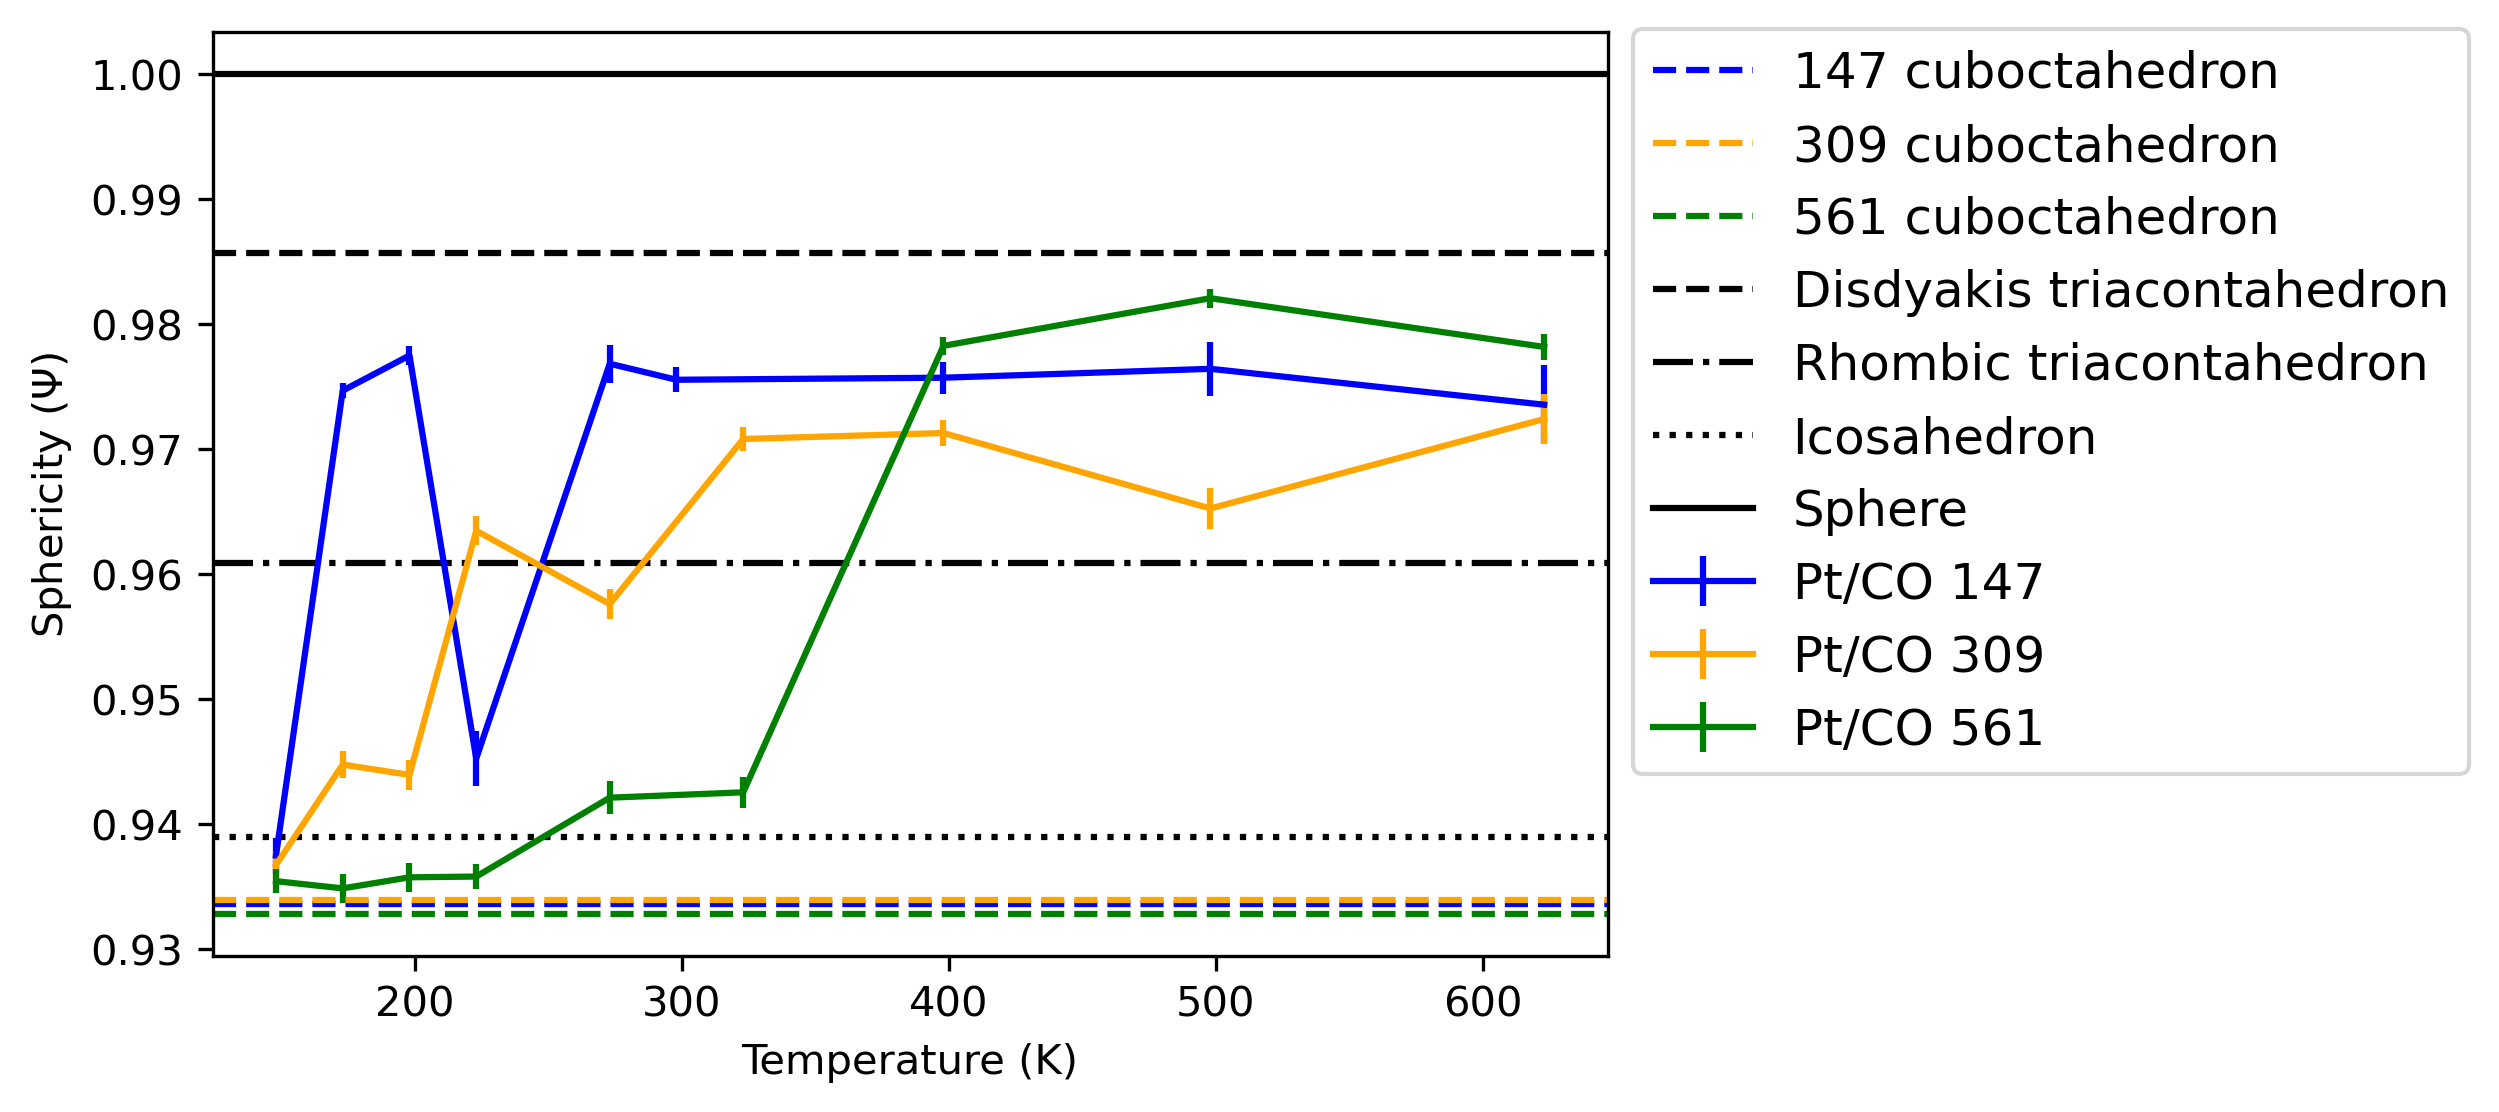

In [100]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
ax.errorbar(x = sphere_dict[147]["temps"], y=sphere_dict[147]["mean"], yerr=sphere_dict[147]["std"], label="Pt/CO 147", color= "blue")
ax.errorbar(x = sphere_dict[309]["temps"], y=sphere_dict[309]["mean"], yerr=sphere_dict[309]["std"], label="Pt/CO 309",  color= "orange")
ax.errorbar(x = sphere_dict[561]["temps"], y=sphere_dict[561]["mean"], yerr=sphere_dict[561]["std"], label="Pt/CO 561",  color= "green")
ax.axhline(y=benchmark_sphericity[147], label="147 cuboctahedron", linestyle='--', color='blue')
ax.axhline(y=benchmark_sphericity[309], label="309 cuboctahedron",linestyle='--', color='orange')
ax.axhline(y=benchmark_sphericity[561], label="561 cuboctahedron", linestyle='--', color='green')
ax.axhline(y=[.9857], label="Disdyakis triacontahedron", linestyle='--', color='black')
ax.axhline(y=[.9609], label="Rhombic triacontahedron", linestyle='dashdot', color='black')
ax.axhline(y=[.939], label="Icosahedron", linestyle=':', color='black')
ax.axhline(y=[1], label="Sphere", linestyle='-', color='black')
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Sphericity ($\Psi$)")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1.03), fontsize=12)


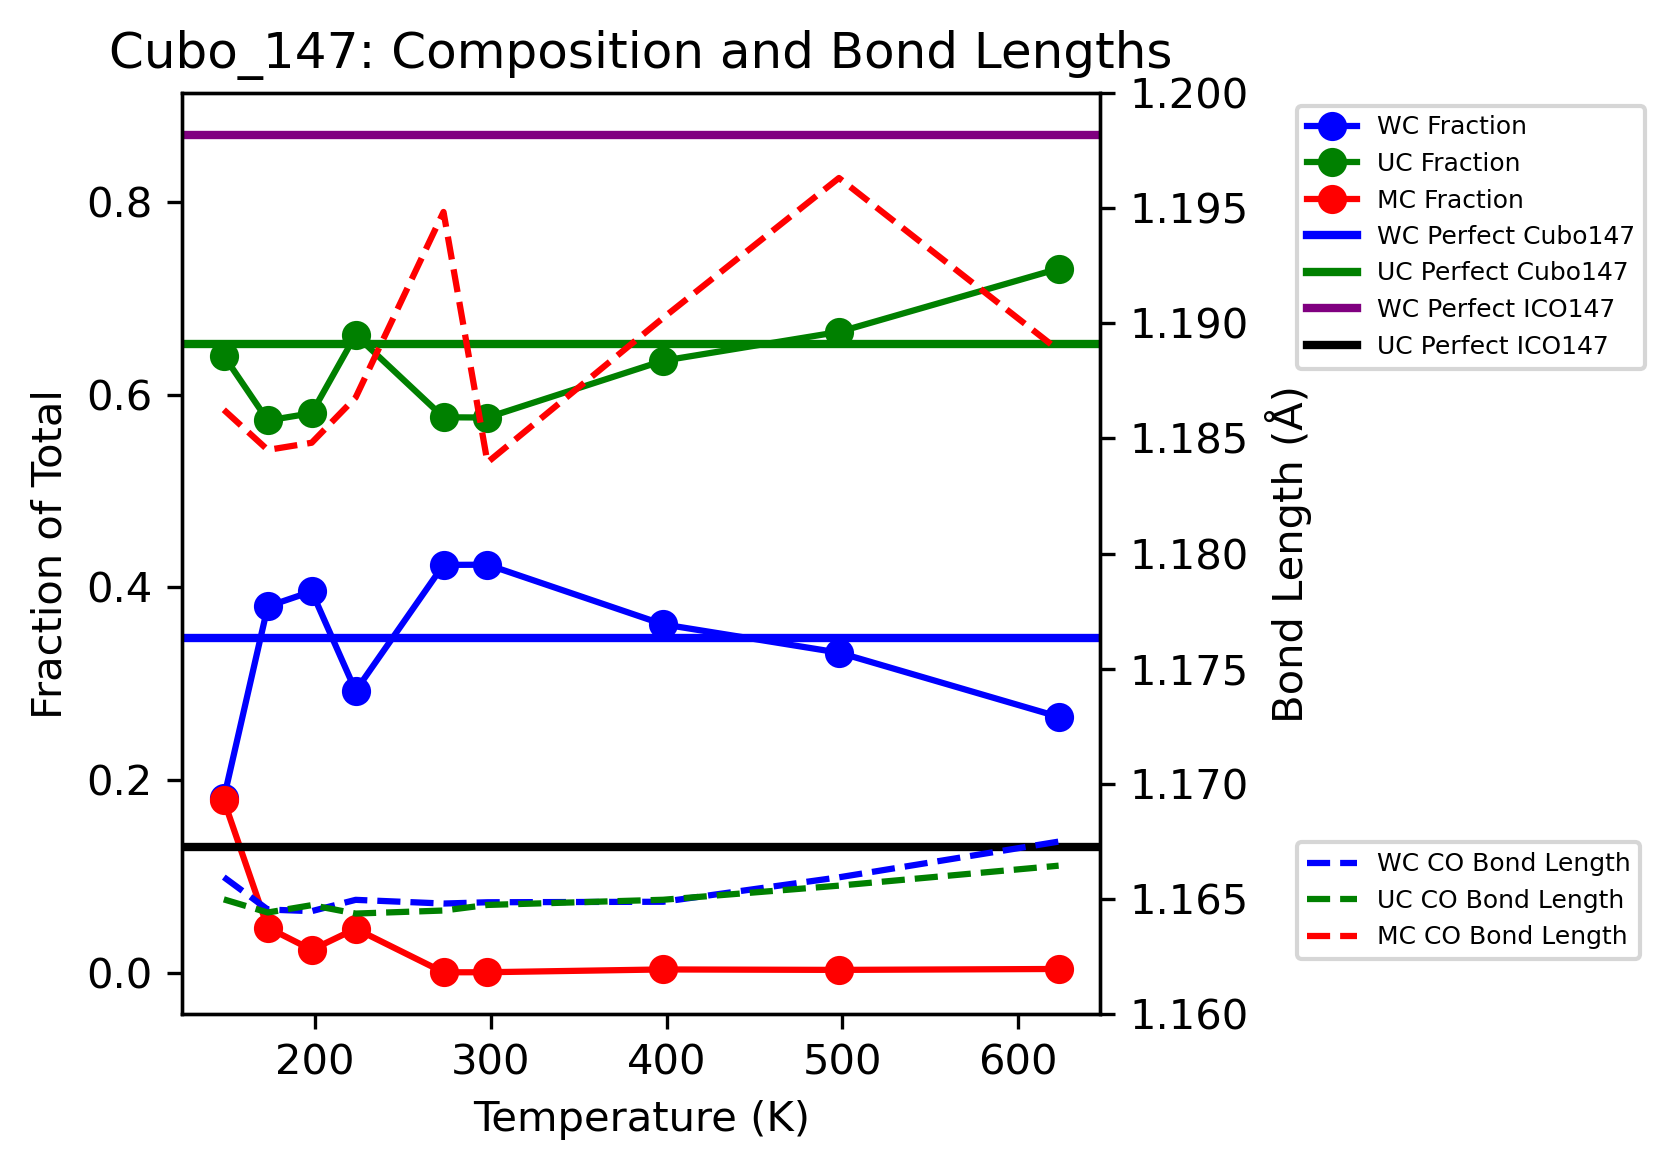

In [11]:
data_names = ["148K_3","173K_6", "198K_6", "223K_6", "273K_6", "298K_6", "398K_6", "498K_6", "623K_6"]
bond_lengths_147 = {}
asp = {}
for i in data_names:
    n_WC, n_UC, n_multi, r_WC, r_UC, r_multi = bond_lengths_WCUCMC(cluster_dict_147[i])
    bond_lengths_147[i] = {"n_WC": n_WC, "n_UC": n_UC, "n_multi": n_multi, "r_WC": r_WC, "r_UC": r_UC, "r_multi": r_multi}
    asp[i] = average_surface_pt(cluster_dict_147[i])


fig, ax1 = plt.subplots(figsize=(6, 4), dpi=300)

# Aggregate data for plotting
temperatures = np.array([int(i.split("K")[0]) for i in data_names])
totals = np.array([bond_lengths_147[i]["n_WC"] + bond_lengths_147[i]["n_UC"] + bond_lengths_147[i]["n_multi"] for i in data_names])
n_WC = np.array([bond_lengths_147[i]["n_WC"] / total for i, total in zip(data_names, totals)])
n_UC = np.array([bond_lengths_147[i]["n_UC"] / total for i, total in zip(data_names, totals)])
n_multi = np.array([bond_lengths_147[i]["n_multi"] / total for i, total in zip(data_names, totals)])

# Plotting fractions on primary y-axis
ax1.plot(temperatures, n_WC, label="WC Fraction", marker='o', color='b')
ax1.plot(temperatures, n_UC, label="UC Fraction", marker='o', color='g')
ax1.plot(temperatures, n_multi, label="MC Fraction", marker='o', color='r')
ax1.set_xlabel("Temperature (K)")
ax1.set_ylabel("Fraction of Total")

# Secondary axis for bond lengths
ax2 = ax1.twinx()
r_WC = np.array([bond_lengths_147[i]["r_WC"] for i in data_names])
r_UC = np.array([bond_lengths_147[i]["r_UC"] for i in data_names])
r_multi = np.array([bond_lengths_147[i]["r_multi"] for i in data_names])
ax2.plot(temperatures, r_WC, label="WC CO Bond Length", linestyle='--', color='b')
ax2.plot(temperatures, r_UC, label="UC CO Bond Length", linestyle='--', color='g')
ax2.plot(temperatures, r_multi, label="MC CO Bond Length", linestyle='--', color='r')
ax2.set_ylabel("Bond Length (Å)")
ax2.set_ylim(1.16, 1.2)

# Adding constant lines for f_WC_147 and f_UC_147
ax1.axhline(y=f_WC_147, color='blue', linestyle='-', linewidth=2, label="WC Perfect Cubo147")
ax1.axhline(y=f_UC_147, color='green', linestyle='-', linewidth=2, label="UC Perfect Cubo147")
ax1.axhline(y=f_WC_147_ico, color='purple', linestyle='-', linewidth=2, label="WC Perfect ICO147")
ax1.axhline(y=f_UC_147_ico, color='black', linestyle='-', linewidth=2, label="UC Perfect ICO147")

# Adjusting legend positioning for ax1
ax1.legend(loc='upper left', bbox_to_anchor=(1.2, 1), fontsize=6)

# Adjusting legend positioning for ax2
ax2.legend(loc='upper left', bbox_to_anchor=(1.2, 0.2), fontsize=6)


plt.title("Cubo_147: Composition and Bond Lengths")
plt.tight_layout()
plt.show()

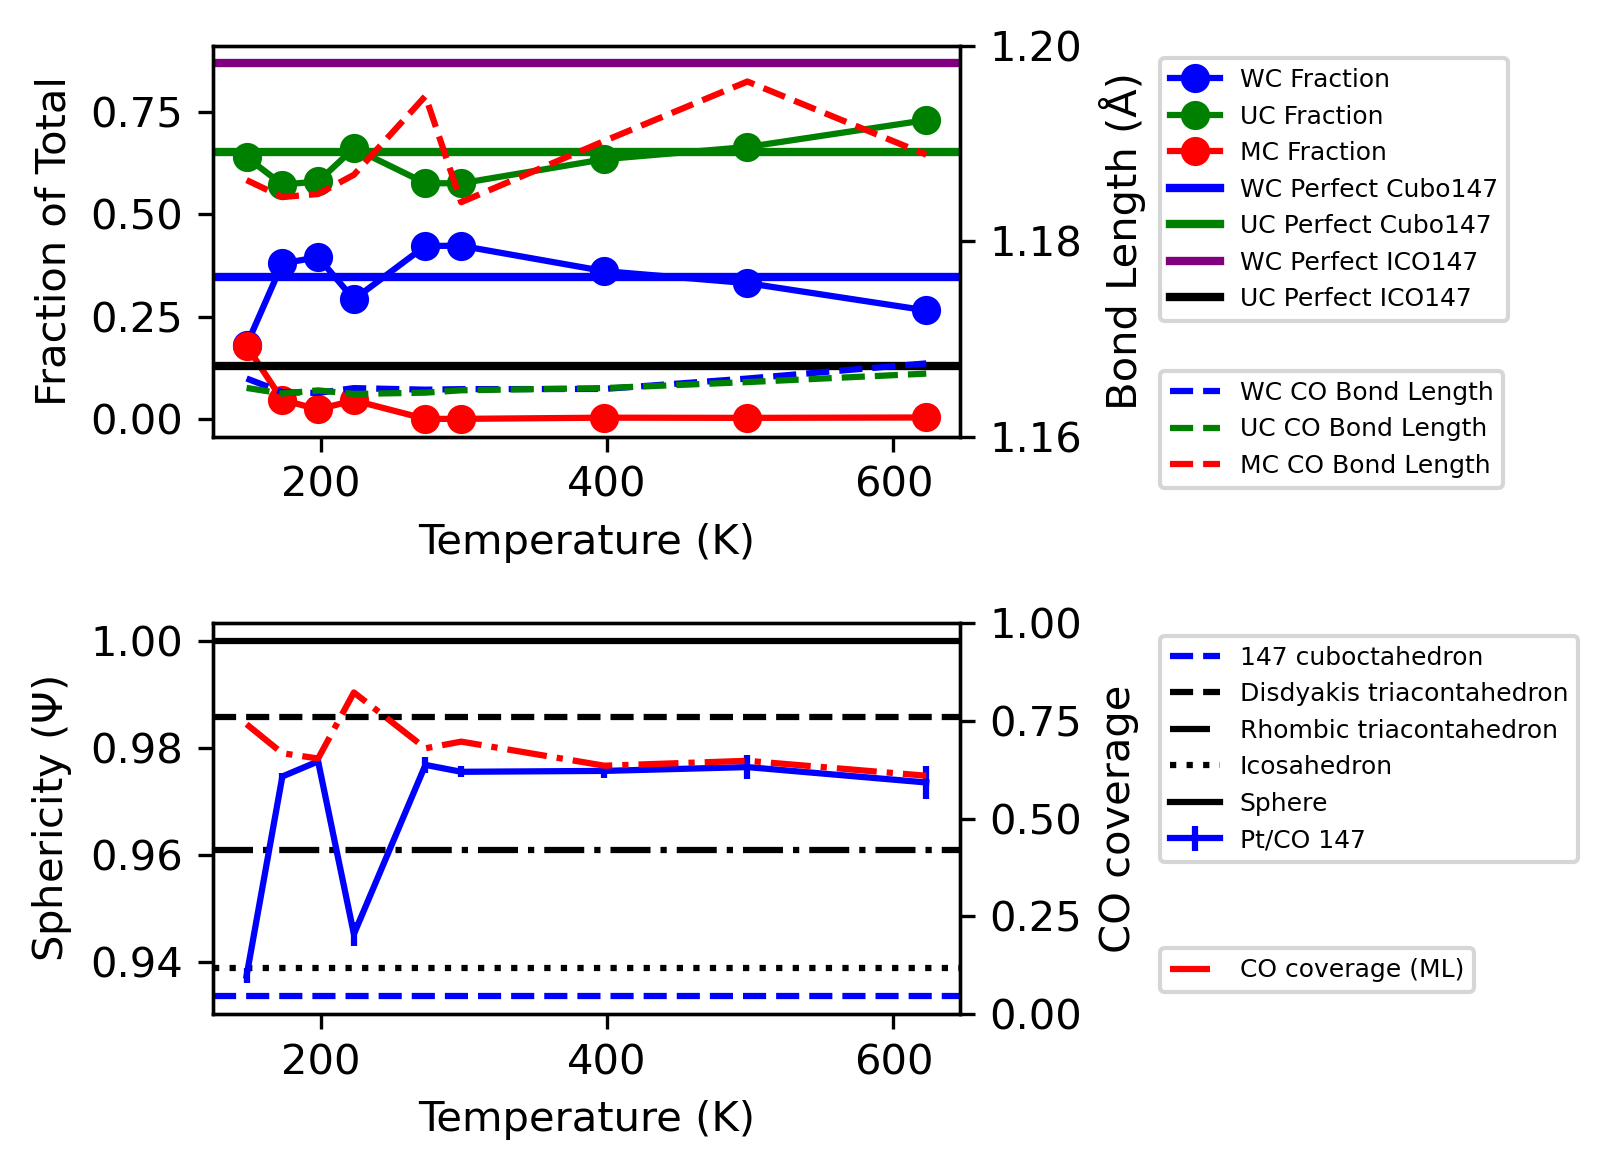

In [189]:
data_names = ["148K_3","173K_6", "198K_6", "223K_6", "273K_6", "298K_6", "398K_6", "498K_6", "623K_6"]
bond_lengths_147 = {}
asp = {}
for i in data_names:
    n_WC, n_UC, n_multi, r_WC, r_UC, r_multi = bond_lengths_WCUCMC(cluster_dict_147[i])
    bond_lengths_147[i] = {"n_WC": n_WC, "n_UC": n_UC, "n_multi": n_multi, "r_WC": r_WC, "r_UC": r_UC, "r_multi": r_multi}
    asp[i] = average_surface_pt(cluster_dict_147[i])

surface_pt = np.array([*asp.values()], dtype=object)

fig, ax1 = plt.subplots(2,1,figsize=(6, 4), dpi=300)

# Aggregate data for plotting
temperatures = np.array([int(i.split("K")[0]) for i in data_names])
totals = np.array([bond_lengths_147[i]["n_WC"] + bond_lengths_147[i]["n_UC"] + bond_lengths_147[i]["n_multi"] for i in data_names])
n_WC = np.array([bond_lengths_147[i]["n_WC"] / total for i, total in zip(data_names, totals)])
n_UC = np.array([bond_lengths_147[i]["n_UC"] / total for i, total in zip(data_names, totals)])
n_multi = np.array([bond_lengths_147[i]["n_multi"] / total for i, total in zip(data_names, totals)])

# Plotting fractions on primary y-axis
ax1[0].plot(temperatures, n_WC, label="WC Fraction", marker='o', color='b')
ax1[0].plot(temperatures, n_UC, label="UC Fraction", marker='o', color='g')
ax1[0].plot(temperatures, n_multi, label="MC Fraction", marker='o', color='r')
ax1[0].set_xlabel("Temperature (K)")
ax1[0].set_ylabel("Fraction of Total")

# Secondary axis for bond lengths
ax2 = ax1[0].twinx()
r_WC = np.array([bond_lengths_147[i]["r_WC"] for i in data_names])
r_UC = np.array([bond_lengths_147[i]["r_UC"] for i in data_names])
r_multi = np.array([bond_lengths_147[i]["r_multi"] for i in data_names])
ax2.plot(temperatures, r_WC, label="WC CO Bond Length", linestyle='--', color='b')
ax2.plot(temperatures, r_UC, label="UC CO Bond Length", linestyle='--', color='g')
ax2.plot(temperatures, r_multi, label="MC CO Bond Length", linestyle='--', color='r')
ax2.set_ylabel("Bond Length (Å)")
ax2.set_ylim(1.16, 1.2)

# Adding constant lines for f_WC_147 and f_UC_147
ax1[0].axhline(y=f_WC_147, color='blue', linestyle='-', linewidth=2, label="WC Perfect Cubo147")
ax1[0].axhline(y=f_UC_147, color='green', linestyle='-', linewidth=2, label="UC Perfect Cubo147")
ax1[0].axhline(y=f_WC_147_ico, color='purple', linestyle='-', linewidth=2, label="WC Perfect ICO147")
ax1[0].axhline(y=f_UC_147_ico, color='black', linestyle='-', linewidth=2, label="UC Perfect ICO147")

# Adjusting legend positioning for ax1[0]
ax1[0].legend(loc='upper left', bbox_to_anchor=(1.25, 1), fontsize=6)

# Adjusting legend positioning for ax2
ax2.legend(loc='upper left', bbox_to_anchor=(1.25, 0.2), fontsize=6)



ax1[1].errorbar(x = sphere_dict[147]["temps"], y=sphere_dict[147]["mean"], yerr=sphere_dict[147]["std"], label="Pt/CO 147", color= "blue")
#ax1[1].errorbar(x = sphere_dict[309]["temps"], y=sphere_dict[309]["mean"], yerr=sphere_dict[309]["std"], label="Pt/CO 309",  color= "orange")
#ax1[1].errorbar(x = sphere_dict[561]["temps"], y=sphere_dict[561]["mean"], yerr=sphere_dict[561]["std"], label="Pt/CO 561",  color= "green")
ax1[1].axhline(y=benchmark_sphericity[147], label="147 cuboctahedron", linestyle='--', color='blue')
#ax1[1].axhline(y=benchmark_sphericity[309], label="309 cuboctahedron",linestyle='--', color='orange')
#ax1[1].axhline(y=benchmark_sphericity[561], label="561 cuboctahedron", linestyle='--', color='green')
ax1[1].axhline(y=[.9857], label="Disdyakis triacontahedron", linestyle='--', color='black')
ax1[1].axhline(y=[.9609], label="Rhombic triacontahedron", linestyle='dashdot', color='black')
ax1[1].axhline(y=[.939], label="Icosahedron", linestyle=':', color='black')
ax1[1].axhline(y=[1], label="Sphere", linestyle='-', color='black')
ax1[1].set_xlabel("Temperature (K)")
ax1[1].set_ylabel("Sphericity ($\Psi$)")
ax1[1].legend(loc='upper left', bbox_to_anchor=(1.25, 1), fontsize=6)

ax3 = ax1[1].twinx()
ax3.plot(temperatures, totals/surface_pt, linestyle='dashdot',label= "CO coverage (ML)", color='red')
ax3.set_ylabel("CO coverage")
ax3.legend(loc='upper left', bbox_to_anchor=(1.25, 0.2), fontsize=6)
ax3.set_ylim(0, 1)



plt.tight_layout()
plt.show()

array([92.1969696969697, 107.93922651933701, 108.61691542288557,
       92.20398009950249, 104.4776119402985, 104.69651741293532,
       111.05472636815921, 110.96019900497512, 120.4726368159204],
      dtype=object)

## 309

In [19]:
# create the data dictionary
# edit paths

cluster_dict_309 = {}
#for i in ["148", "323", "398", "498", "623"]:
for i in ["148K_3","173K_3", "198K_3", "223K_4", "273K_4", "323K_6", "398K_6", "498K_6", "623K_6"]:

    ###########################################

    traj_dir = '/mnt/a/MD_Trajectories/PtCO/NPs/continued/cubo_309/'
    traj_name = f"Pt309_cuboct_{i}.all.bin"

    #p_name = "Pt309_cuboct_498K"
    #input_dir = "/mnt/a/MD_Trajectories/PtCO/NPs/Inputs/"
    #input_dir = "/mnt/sdcc/sdcc+u/nmarcella/MD_EXAFS_inputs/231228/"

    #pipeline.source.num_frames
    ###########################################
    
    traj_path = traj_dir + traj_name

    pipeline = import_file(traj_path)

    tm = [[1, 0, 0, -100],
                [0,  1, 0,200],
                [0, 0, 1, -100]]

    pipeline.modifiers.append(AffineTransformationModifier(operate_on = {'cell'}, transformation=tm))
    pipeline.modifiers.append(WrapPeriodicImagesModifier())

    test_pl = MD_EXAFS_Analysis_Pipeline_PtCO(pipeline, file_params={"framerange": range(0,pipeline.source.num_frames,100),"atoms":{"Pt":1, "C":2, "O":3}, "cutoff":3}, custom_analysis_func=find_adsorbed_CO)
    #test_pl = MD_EXAFS_Binary_Pipeline_General(pipeline, file_params={"framerange": range(15999,16000),"atoms":{"Pt":1}, "cutoff":3})
    test_pl.run()

    data = test_pl.data
    n_atoms = test_pl.n_atoms_list

    n_atoms = np.array(n_atoms)
    n_co = np.mean(n_atoms[:,1])

    cluster_dict_309[i] = {"CO" :n_atoms[:,1], "data":data}

In [68]:
sphere_list_mean = []
sphere_list_std = []
for i in ["148K_3","173K_3", "198K_3", "223K_4", "273K_4", "323K_6", "398K_6", "498K_6", "623K_6"]:
    sphere_list_i = []
    for data in cluster_dict_309[i]["data"]:
        points = filter_pt_atoms(data)
        sphericity = calculate_sphericity(points)
        sphere_list_i.append(sphericity)
    sphere_list_i = np.array(sphere_list_i)
    sphere_mean = np.mean(sphere_list_i)
    sphere_std = np.std(sphere_list_i)
    sphere_list_mean.append(sphere_mean)
    sphere_list_std.append(sphere_std)

sphere_dict[309]={"temps":[148, 173, 198, 223, 273, 323, 398, 498, 623], "mean":sphere_list_mean, "std": sphere_list_std}

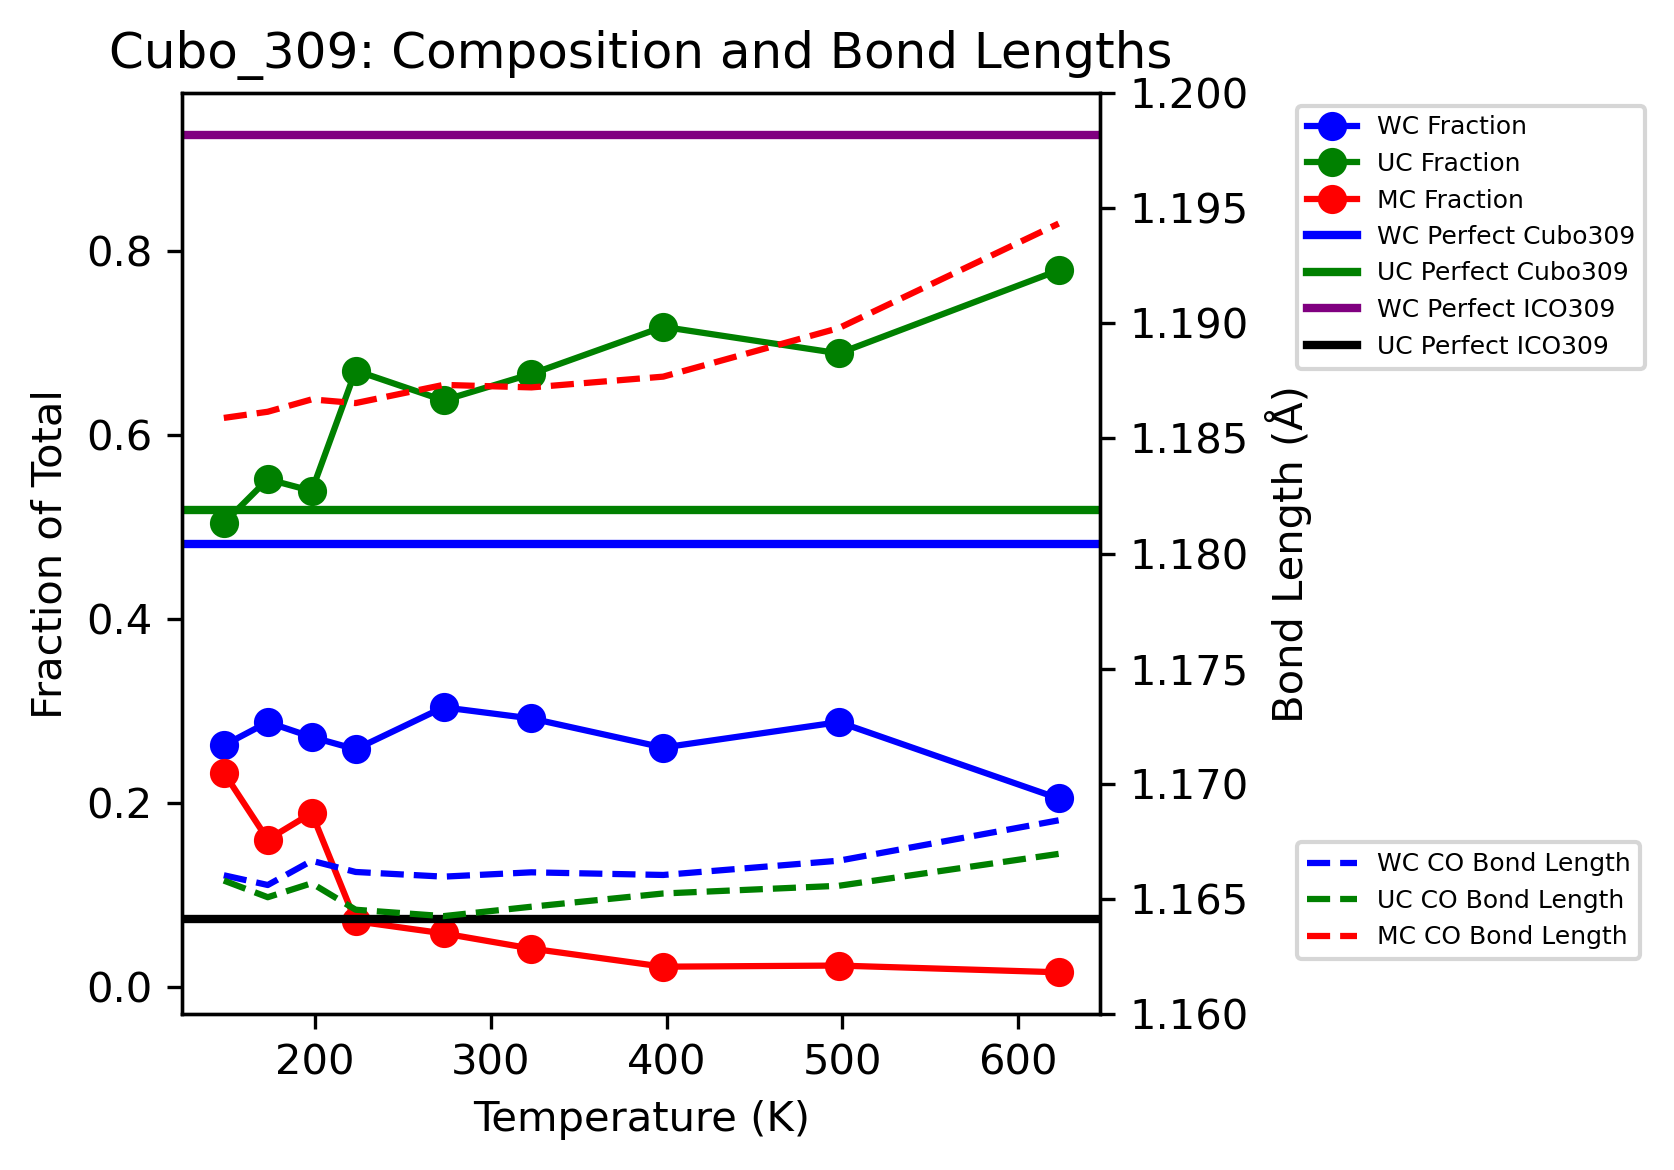

In [12]:
data_names = ["148K_3","173K_3", "198K_3", "223K_4", "273K_4", "323K_6", "398K_6", "498K_6", "623K_6"]
bond_lengths_309 = {}
for i in data_names:
    n_WC, n_UC, n_multi, r_WC, r_UC, r_multi = bond_lengths_WCUCMC(cluster_dict_309[i])
    bond_lengths_309[i] = {"n_WC": n_WC, "n_UC": n_UC, "n_multi": n_multi, "r_WC": r_WC, "r_UC": r_UC, "r_multi": r_multi}

fig, ax1 = plt.subplots(figsize=(6, 4), dpi=300)

# Aggregate data for plotting
temperatures = np.array([int(i.split("K")[0]) for i in data_names])
totals = np.array([bond_lengths_309[i]["n_WC"] + bond_lengths_309[i]["n_UC"] + bond_lengths_309[i]["n_multi"] for i in data_names])
n_WC = np.array([bond_lengths_309[i]["n_WC"] / total for i, total in zip(data_names, totals)])
n_UC = np.array([bond_lengths_309[i]["n_UC"] / total for i, total in zip(data_names, totals)])
n_multi = np.array([bond_lengths_309[i]["n_multi"] / total for i, total in zip(data_names, totals)])

# Plotting fractions on primary y-axis
ax1.plot(temperatures, n_WC, label="WC Fraction", marker='o', color='b')
ax1.plot(temperatures, n_UC, label="UC Fraction", marker='o', color='g')
ax1.plot(temperatures, n_multi, label="MC Fraction", marker='o', color='r')
ax1.set_xlabel("Temperature (K)")
ax1.set_ylabel("Fraction of Total")

# Secondary axis for bond lengths
ax2 = ax1.twinx()
r_WC = np.array([bond_lengths_309[i]["r_WC"] for i in data_names])
r_UC = np.array([bond_lengths_309[i]["r_UC"] for i in data_names])
r_multi = np.array([bond_lengths_309[i]["r_multi"] for i in data_names])
ax2.plot(temperatures, r_WC, label="WC CO Bond Length", linestyle='--', color='b')
ax2.plot(temperatures, r_UC, label="UC CO Bond Length", linestyle='--', color='g')
ax2.plot(temperatures, r_multi, label="MC CO Bond Length", linestyle='--', color='r')
ax2.set_ylabel("Bond Length (Å)")
ax2.set_ylim(1.16, 1.2)

# Adding constant lines for f_WC_309 and f_UC_309
ax1.axhline(y=f_WC_309, color='blue', linestyle='-', linewidth=2, label="WC Perfect Cubo309")
ax1.axhline(y=f_UC_309, color='green', linestyle='-', linewidth=2, label="UC Perfect Cubo309")

ax1.axhline(y=f_WC_309_ico, color='purple', linestyle='-', linewidth=2, label="WC Perfect ICO309")
ax1.axhline(y=f_UC_309_ico, color='black', linestyle='-', linewidth=2, label="UC Perfect ICO309")

# Adjusting legend positioning for ax1
ax1.legend(loc='upper left', bbox_to_anchor=(1.2, 1), fontsize=6)

# Adjusting legend positioning for ax2
ax2.legend(loc='upper left', bbox_to_anchor=(1.2, 0.2), fontsize=6)


plt.title("Cubo_309: Composition and Bond Lengths")
plt.tight_layout()
plt.show()

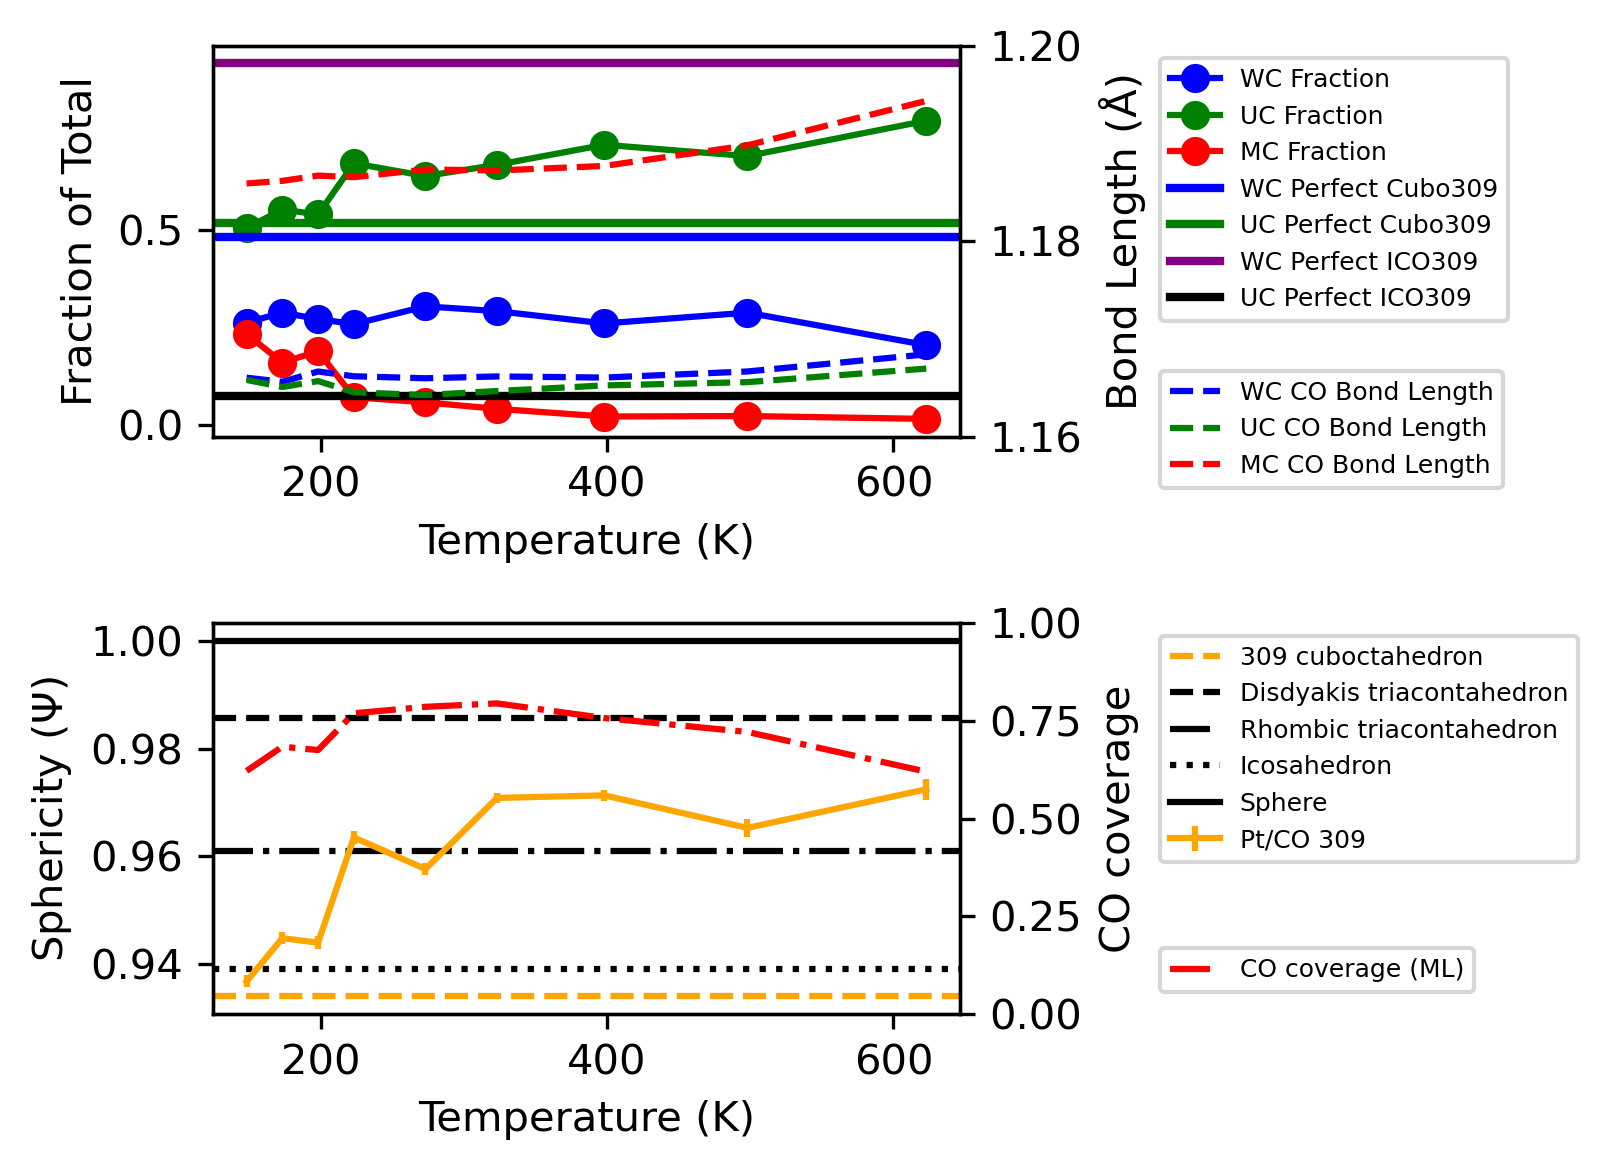

In [192]:
data_names = ["148K_3","173K_3", "198K_3", "223K_4", "273K_4", "323K_6", "398K_6", "498K_6", "623K_6"]
bond_lengths_309 = {}
asp = {}
for i in data_names:
    n_WC, n_UC, n_multi, r_WC, r_UC, r_multi = bond_lengths_WCUCMC(cluster_dict_309[i])
    bond_lengths_309[i] = {"n_WC": n_WC, "n_UC": n_UC, "n_multi": n_multi, "r_WC": r_WC, "r_UC": r_UC, "r_multi": r_multi}
    asp[i] = average_surface_pt(cluster_dict_309[i])

surface_pt = np.array([*asp.values()], dtype=object)

fig, ax1 = plt.subplots(2, 1, figsize=(6, 4), dpi=300)

# Aggregate data for plotting
temperatures = np.array([int(i.split("K")[0]) for i in data_names])
totals = np.array([bond_lengths_309[i]["n_WC"] + bond_lengths_309[i]["n_UC"] + bond_lengths_309[i]["n_multi"] for i in data_names])
n_WC = np.array([bond_lengths_309[i]["n_WC"] / total for i, total in zip(data_names, totals)])
n_UC = np.array([bond_lengths_309[i]["n_UC"] / total for i, total in zip(data_names, totals)])
n_multi = np.array([bond_lengths_309[i]["n_multi"] / total for i, total in zip(data_names, totals)])

# Plotting fractions on primary y-axis
ax1[0].plot(temperatures, n_WC, label="WC Fraction", marker='o', color='b')
ax1[0].plot(temperatures, n_UC, label="UC Fraction", marker='o', color='g')
ax1[0].plot(temperatures, n_multi, label="MC Fraction", marker='o', color='r')
ax1[0].set_xlabel("Temperature (K)")
ax1[0].set_ylabel("Fraction of Total")

# Secondary axis for bond lengths
ax2 = ax1[0].twinx()
r_WC = np.array([bond_lengths_309[i]["r_WC"] for i in data_names])
r_UC = np.array([bond_lengths_309[i]["r_UC"] for i in data_names])
r_multi = np.array([bond_lengths_309[i]["r_multi"] for i in data_names])
ax2.plot(temperatures, r_WC, label="WC CO Bond Length", linestyle='--', color='b')
ax2.plot(temperatures, r_UC, label="UC CO Bond Length", linestyle='--', color='g')
ax2.plot(temperatures, r_multi, label="MC CO Bond Length", linestyle='--', color='r')
ax2.set_ylabel("Bond Length (Å)")
ax2.set_ylim(1.16, 1.2)

# Adding constant lines for f_WC_309 and f_UC_309
ax1[0].axhline(y=f_WC_309, color='blue', linestyle='-', linewidth=2, label="WC Perfect Cubo309")
ax1[0].axhline(y=f_UC_309, color='green', linestyle='-', linewidth=2, label="UC Perfect Cubo309")

ax1[0].axhline(y=f_WC_309_ico, color='purple', linestyle='-', linewidth=2, label="WC Perfect ICO309")
ax1[0].axhline(y=f_UC_309_ico, color='black', linestyle='-', linewidth=2, label="UC Perfect ICO309")

# Adjusting legend positioning for ax1
ax1[0].legend(loc='upper left', bbox_to_anchor=(1.25, 1), fontsize=6)

# Adjusting legend positioning for ax2
ax2.legend(loc='upper left', bbox_to_anchor=(1.25, 0.2), fontsize=6)



#ax1[1].errorbar(x = sphere_dict[309]["temps"], y=sphere_dict[309]["mean"], yerr=sphere_dict[309]["std"], label="Pt/CO 309", color= "blue")
ax1[1].errorbar(x = sphere_dict[309]["temps"], y=sphere_dict[309]["mean"], yerr=sphere_dict[309]["std"], label="Pt/CO 309",  color= "orange")
#ax1[1].errorbar(x = sphere_dict[561]["temps"], y=sphere_dict[561]["mean"], yerr=sphere_dict[561]["std"], label="Pt/CO 561",  color= "green")
#ax1[1].axhline(y=benchmark_sphericity[309], label="309 cuboctahedron", linestyle='--', color='blue')
ax1[1].axhline(y=benchmark_sphericity[309], label="309 cuboctahedron",linestyle='--', color='orange')
#ax1[1].axhline(y=benchmark_sphericity[561], label="561 cuboctahedron", linestyle='--', color='green')
ax1[1].axhline(y=[.9857], label="Disdyakis triacontahedron", linestyle='--', color='black')
ax1[1].axhline(y=[.9609], label="Rhombic triacontahedron", linestyle='dashdot', color='black')
ax1[1].axhline(y=[.939], label="Icosahedron", linestyle=':', color='black')
ax1[1].axhline(y=[1], label="Sphere", linestyle='-', color='black')
ax1[1].set_xlabel("Temperature (K)")
ax1[1].set_ylabel("Sphericity ($\Psi$)")
ax1[1].legend(loc='upper left', bbox_to_anchor=(1.25, 1), fontsize=6)

ax3 = ax1[1].twinx()
ax3.plot(temperatures, totals/surface_pt, linestyle='dashdot',label= "CO coverage (ML)", color='red')
ax3.set_ylabel("CO coverage")
ax3.legend(loc='upper left', bbox_to_anchor=(1.25, 0.2), fontsize=6)
ax3.set_ylim(0, 1)



plt.tight_layout()
plt.show()

## 561

In [20]:
# create the data dictionary
# edit paths

cluster_dict_561 = {}
#for i in ["148", "323", "398", "498", "623"]:
for i in ["148K_5","173K_7", "198K_7", "223K_7", "273K_7", "298K_6", "398K_6", "498K_6", "623K_6"]:

    ###########################################

    traj_dir = '/mnt/a/MD_Trajectories/PtCO/NPs/continued/cubo_561/'
    traj_name = f"Pt561_cuboct_{i}.all.bin"

    #p_name = "Pt561_cuboct_498K"
    #input_dir = "/mnt/a/MD_Trajectories/PtCO/NPs/Inputs/"
    #input_dir = "/mnt/sdcc/sdcc+u/nmarcella/MD_EXAFS_inputs/231228/"

    #pipeline.source.num_frames
    ###########################################
    
    traj_path = traj_dir + traj_name

    pipeline = import_file(traj_path)

    tm = [[1, 0, 0, -100],
                [0,  1, 0,200],
                [0, 0, 1, -100]]

    pipeline.modifiers.append(AffineTransformationModifier(operate_on = {'cell'}, transformation=tm))
    pipeline.modifiers.append(WrapPeriodicImagesModifier()) 

    test_pl = MD_EXAFS_Analysis_Pipeline_PtCO(pipeline, file_params={"framerange": range(0,pipeline.source.num_frames,100),"atoms":{"Pt":1, "C":2, "O":3}, "cutoff":3}, custom_analysis_func=find_adsorbed_CO)
    #test_pl = MD_EXAFS_Binary_Pipeline_General(pipeline, file_params={"framerange": range(15999,16000),"atoms":{"Pt":1}, "cutoff":3})
    test_pl.run()

    data = test_pl.data
    n_atoms = test_pl.n_atoms_list

    n_atoms = np.array(n_atoms)
    n_co = np.mean(n_atoms[:,1])

    cluster_dict_561[i] = {"CO" :n_atoms[:,1], "data":data}

In [69]:
sphere_list_mean = []
sphere_list_std = []
for i in ["148K_5","173K_7", "198K_7", "223K_7", "273K_7", "298K_6", "398K_6", "498K_6", "623K_6"]:
    sphere_list_i = []
    for data in cluster_dict_561[i]["data"]:
        points = filter_pt_atoms(data)
        sphericity = calculate_sphericity(points)
        sphere_list_i.append(sphericity)
    sphere_list_i = np.array(sphere_list_i)
    sphere_mean = np.mean(sphere_list_i)
    sphere_std = np.std(sphere_list_i)
    sphere_list_mean.append(sphere_mean)
    sphere_list_std.append(sphere_std)

sphere_dict[561]={"temps":[148, 173, 198, 223, 273, 323, 398, 498, 623], "mean":sphere_list_mean, "std": sphere_list_std}

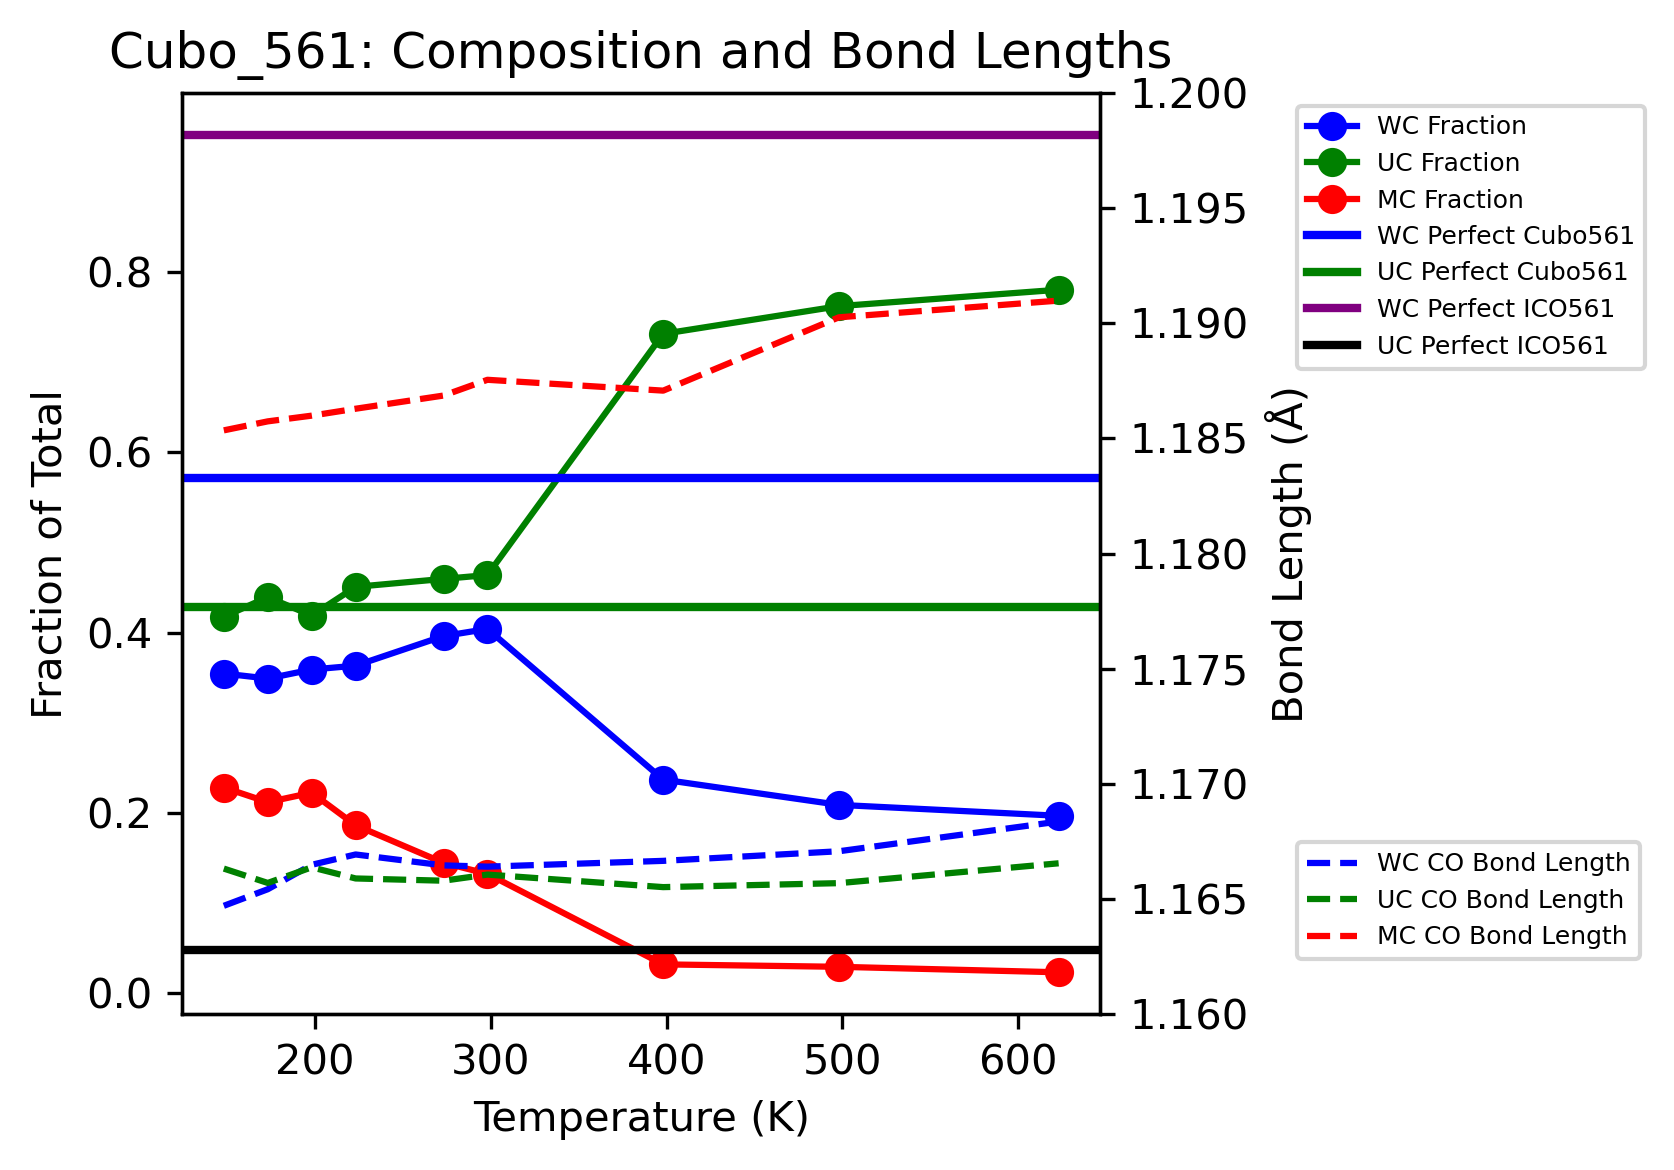

In [141]:
data_names = ["148K_5","173K_7", "198K_7", "223K_7", "273K_7", "298K_6", "398K_6", "498K_6", "623K_6"]
bond_lengths_561 = {}
asp = {}
for i in data_names:
    n_WC, n_UC, n_multi, r_WC, r_UC, r_multi = bond_lengths_WCUCMC(cluster_dict_561[i])
    bond_lengths_561[i] = {"n_WC": n_WC, "n_UC": n_UC, "n_multi": n_multi, "r_WC": r_WC, "r_UC": r_UC, "r_multi": r_multi}
    asp[i] = average_surface_pt(cluster_dict_561[i])

surface_pt = np.array([*asp.values()], dtype=object)

fig, ax1 = plt.subplots(figsize=(6, 4), dpi=300)

# Aggregate data for plotting
temperatures = np.array([int(i.split("K")[0]) for i in data_names])
totals = np.array([bond_lengths_561[i]["n_WC"] + bond_lengths_561[i]["n_UC"] + bond_lengths_561[i]["n_multi"] for i in data_names])
n_WC = np.array([bond_lengths_561[i]["n_WC"] / total for i, total in zip(data_names, totals)])
n_UC = np.array([bond_lengths_561[i]["n_UC"] / total for i, total in zip(data_names, totals)])
n_multi = np.array([bond_lengths_561[i]["n_multi"] / total for i, total in zip(data_names, totals)])

# Plotting fractions on primary y-axis
ax1.plot(temperatures, n_WC, label="WC Fraction", marker='o', color='b')
ax1.plot(temperatures, n_UC, label="UC Fraction", marker='o', color='g')
ax1.plot(temperatures, n_multi, label="MC Fraction", marker='o', color='r')
ax1.set_xlabel("Temperature (K)")
ax1.set_ylabel("Fraction of Total")

# Secondary axis for bond lengths
ax2 = ax1.twinx()
r_WC = np.array([bond_lengths_561[i]["r_WC"] for i in data_names])
r_UC = np.array([bond_lengths_561[i]["r_UC"] for i in data_names])
r_multi = np.array([bond_lengths_561[i]["r_multi"] for i in data_names])
ax2.plot(temperatures, r_WC, label="WC CO Bond Length", linestyle='--', color='b')
ax2.plot(temperatures, r_UC, label="UC CO Bond Length", linestyle='--', color='g')
ax2.plot(temperatures, r_multi, label="MC CO Bond Length", linestyle='--', color='r')
ax2.set_ylabel("Bond Length (Å)")
ax2.set_ylim(1.16, 1.2)

# Adding constant lines for f_WC_561 and f_UC_561
ax1.axhline(y=f_WC_561, color='blue', linestyle='-', linewidth=2, label="WC Perfect Cubo561")
ax1.axhline(y=f_UC_561, color='green', linestyle='-', linewidth=2, label="UC Perfect Cubo561")

ax1.axhline(y=f_WC_561_ico, color='purple', linestyle='-', linewidth=2, label="WC Perfect ICO561")
ax1.axhline(y=f_UC_561_ico, color='black', linestyle='-', linewidth=2, label="UC Perfect ICO561")

# Adjusting legend positioning for ax1
ax1.legend(loc='upper left', bbox_to_anchor=(1.2, 1), fontsize=6)

# Adjusting legend positioning for ax2
ax2.legend(loc='upper left', bbox_to_anchor=(1.2, 0.2), fontsize=6)


plt.title("Cubo_561: Composition and Bond Lengths")
plt.tight_layout()
plt.show()

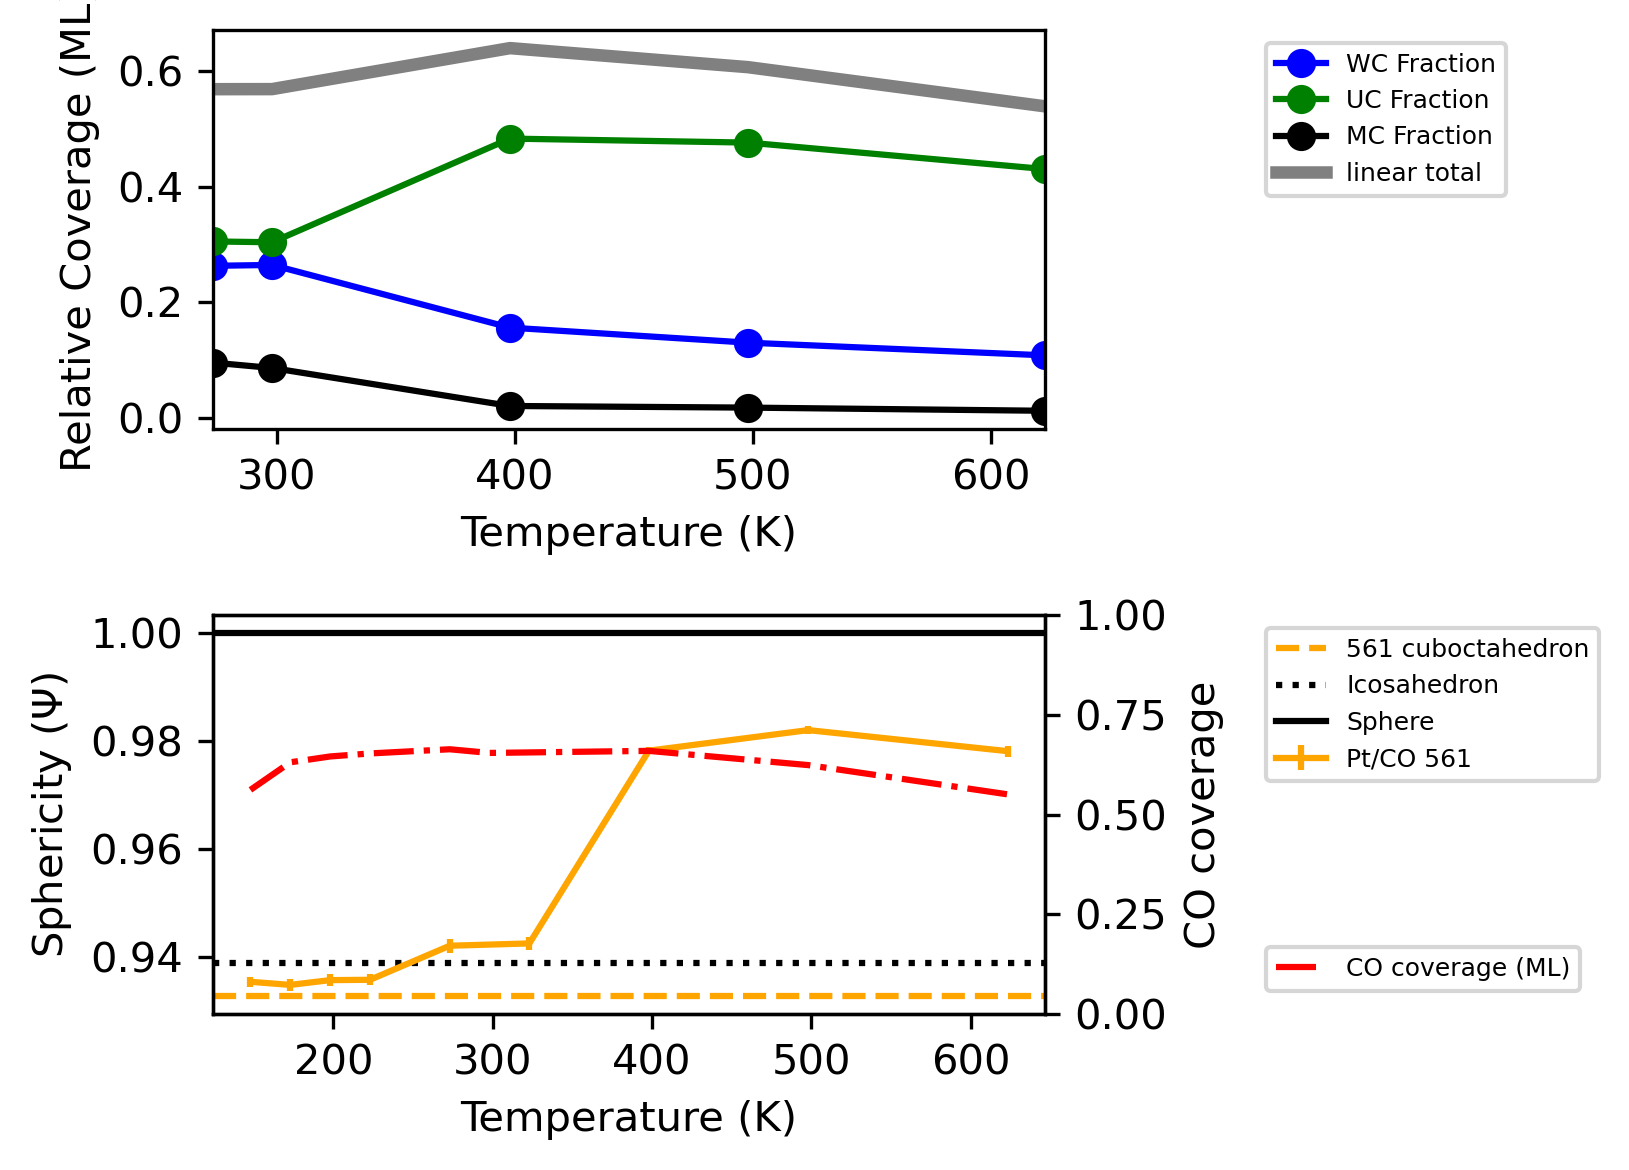

In [213]:
data_names = ["148K_5","173K_7", "198K_7", "223K_7", "273K_7", "298K_6", "398K_6", "498K_6", "623K_6"]
bond_lengths_561 = {}
asp = {}
for i in data_names:
    n_WC, n_UC, n_multi, r_WC, r_UC, r_multi = bond_lengths_WCUCMC(cluster_dict_561[i])
    bond_lengths_561[i] = {"n_WC": n_WC, "n_UC": n_UC, "n_multi": n_multi, "r_WC": r_WC, "r_UC": r_UC, "r_multi": r_multi}
    asp[i] = average_surface_pt(cluster_dict_561[i])

surface_pt = np.array([*asp.values()], dtype=object)

fig, ax1 = plt.subplots(2,1, figsize=(6, 4), dpi=300)

# Aggregate data for plotting
temperatures = np.array([int(i.split("K")[0]) for i in data_names])
totals = np.array([bond_lengths_561[i]["n_WC"] + bond_lengths_561[i]["n_UC"] + bond_lengths_561[i]["n_multi"] for i in data_names])
n_WC = np.array([bond_lengths_561[i]["n_WC"] / total for i, total in zip(data_names, totals)])
n_UC = np.array([bond_lengths_561[i]["n_UC"] / total for i, total in zip(data_names, totals)])
n_multi = np.array([bond_lengths_561[i]["n_multi"] / total for i, total in zip(data_names, totals)])

# Plotting fractions on primary y-axis
ax1[0].plot(temperatures, n_WC*(totals/surface_pt), label="WC Fraction", marker='o', color='b')
ax1[0].plot(temperatures, n_UC*(totals/surface_pt), label="UC Fraction", marker='o', color='g')
# normalized absorbance
ax1[0].plot(temperatures, n_multi*(totals/surface_pt), label="MC Fraction", marker='o', color='black')
ax1[0].plot(temperatures, (n_WC+n_UC)*(totals/surface_pt), lw = 3 , color='gray', label ='linear total')

ax1[0].set_xlabel("Temperature (K)")
ax1[0].set_ylabel("Relative Coverage (ML)")
ax1[0].set_xlim(273, 623)

# Secondary axis for bond lengths
#ax2 = ax1[0].twinx()
#r_WC = np.array([bond_lengths_561[i]["r_WC"] for i in data_names])
#r_UC = np.array([bond_lengths_561[i]["r_UC"] for i in data_names])
#r_multi = np.array([bond_lengths_561[i]["r_multi"] for i in data_names])
#ax2.plot(temperatures, r_WC, label="WC CO Bond Length", linestyle='--', color='b')
#ax2.plot(temperatures, r_UC, label="UC CO Bond Length", linestyle='--', color='g')
#ax2.plot(temperatures, r_multi, label="MC CO Bond Length", linestyle='--', color='black')
#ax2.set_ylabel("Bond Length (Å)")
#ax2.set_ylim(1.16, 1.2)

# Adding constant lines for f_WC_561 and f_UC_561
#ax1[0].axhline(y=f_WC_561, color='blue', linestyle='-', linewidth=2, label="WC Perfect Cubo561")
#ax1[0].axhline(y=f_UC_561, color='green', linestyle='-', linewidth=2, label="UC Perfect Cubo561")

#ax1[0].axhline(y=f_WC_561_ico, color='purple', linestyle='-', linewidth=2, label="WC Perfect ICO561")
#ax1[0].axhline(y=f_UC_561_ico, color='black', linestyle='-', linewidth=2, label="UC Perfect ICO561")

# Adjusting legend positioning for ax1
ax1[0].legend(loc='upper left', bbox_to_anchor=(1.25, 1), fontsize=6)



# Adjusting legend positioning for ax2
#ax2.legend(loc='upper left', bbox_to_anchor=(1.25, 0.2), fontsize=6)



#ax1[1].errorbar(x = sphere_dict[561]["temps"], y=sphere_dict[561]["mean"], yerr=sphere_dict[561]["std"], label="Pt/CO 561", color= "blue")
ax1[1].errorbar(x = sphere_dict[561]["temps"], y=sphere_dict[561]["mean"], yerr=sphere_dict[561]["std"], label="Pt/CO 561",  color= "orange")
#ax1[1].errorbar(x = sphere_dict[561]["temps"], y=sphere_dict[561]["mean"], yerr=sphere_dict[561]["std"], label="Pt/CO 561",  color= "green")
#ax1[1].axhline(y=benchmark_sphericity[561], label="561 cuboctahedron", linestyle='--', color='blue')
ax1[1].axhline(y=benchmark_sphericity[561], label="561 cuboctahedron",linestyle='--', color='orange')
#ax1[1].axhline(y=benchmark_sphericity[561], label="561 cuboctahedron", linestyle='--', color='green')
#ax1[1].axhline(y=[.9857], label="Disdyakis triacontahedron", linestyle='--', color='black')
#ax1[1].axhline(y=[.9609], label="Rhombic triacontahedron", linestyle='dashdot', color='black')
ax1[1].axhline(y=[.939], label="Icosahedron", linestyle=':', color='black')
ax1[1].axhline(y=[1], label="Sphere", linestyle='-', color='black')
ax1[1].set_xlabel("Temperature (K)")
ax1[1].set_ylabel("Sphericity ($\Psi$)")
ax1[1].legend(loc='upper left', bbox_to_anchor=(1.25, 1), fontsize=6)

ax3 = ax1[1].twinx()
ax3.plot(temperatures, totals/surface_pt, linestyle='dashdot',label= "CO coverage (ML)", color='red')
ax3.set_ylabel("CO coverage")
ax3.legend(loc='upper left', bbox_to_anchor=(1.25, 0.2), fontsize=6)
ax3.set_ylim(0, 1)



plt.tight_layout()
plt.show()

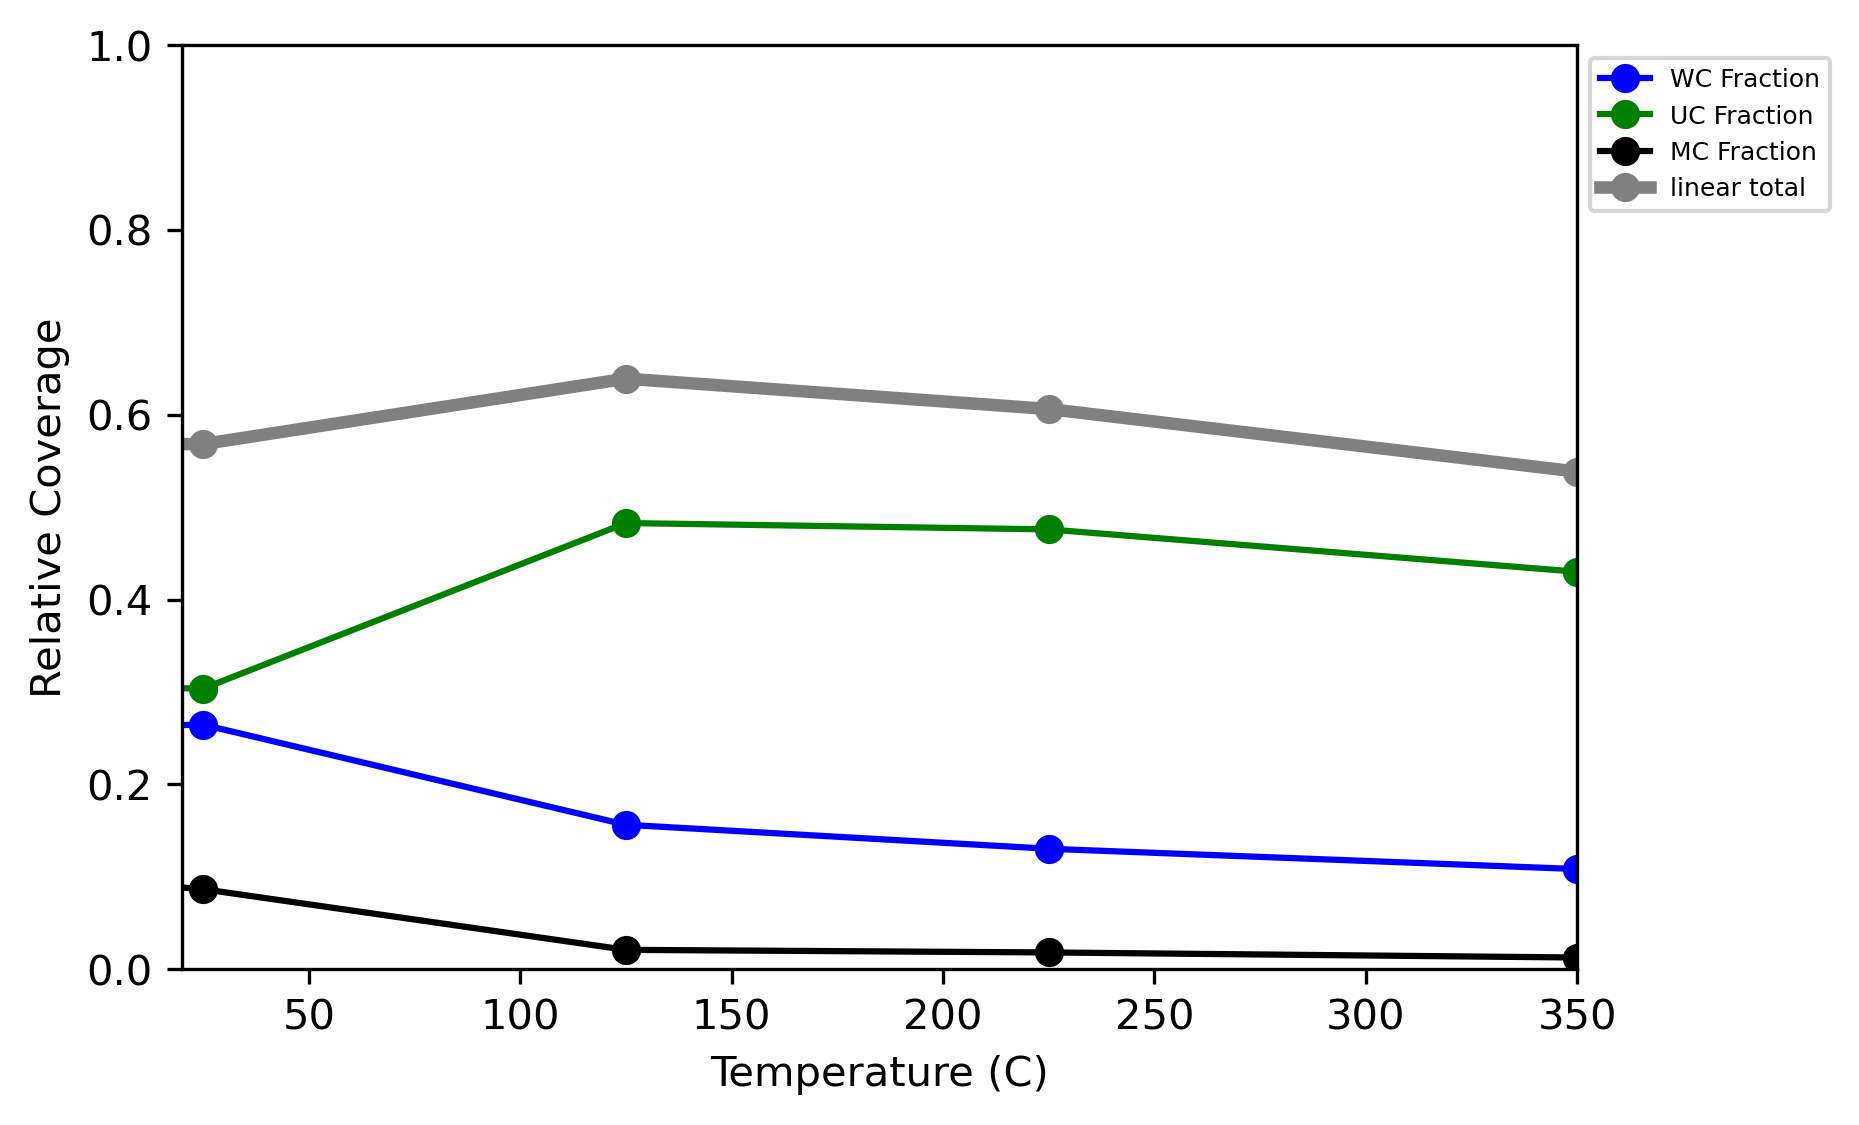

In [224]:
data_names = ["148K_5","173K_7", "198K_7", "223K_7", "273K_7", "298K_6", "398K_6", "498K_6", "623K_6"]
bond_lengths_561 = {}
asp = {}
for i in data_names:
    n_WC, n_UC, n_multi, r_WC, r_UC, r_multi = bond_lengths_WCUCMC(cluster_dict_561[i])
    bond_lengths_561[i] = {"n_WC": n_WC, "n_UC": n_UC, "n_multi": n_multi, "r_WC": r_WC, "r_UC": r_UC, "r_multi": r_multi}
    asp[i] = average_surface_pt(cluster_dict_561[i])

surface_pt = np.array([*asp.values()], dtype=object)

fig, ax1 = plt.subplots(1,1, figsize=(6, 4), dpi=300)

# Aggregate data for plotting
temperatures = np.array([int(i.split("K")[0]) for i in data_names])-273
totals = np.array([bond_lengths_561[i]["n_WC"] + bond_lengths_561[i]["n_UC"] + bond_lengths_561[i]["n_multi"] for i in data_names])
n_WC = np.array([bond_lengths_561[i]["n_WC"] / total for i, total in zip(data_names, totals)])
n_UC = np.array([bond_lengths_561[i]["n_UC"] / total for i, total in zip(data_names, totals)])
n_multi = np.array([bond_lengths_561[i]["n_multi"] / total for i, total in zip(data_names, totals)])

# Plotting fractions on primary y-axis
ax1.plot(temperatures, n_WC*(totals/surface_pt), label="WC Fraction", marker='o', color='b')
ax1.plot(temperatures, n_UC*(totals/surface_pt), label="UC Fraction", marker='o', color='g')
# normalized absorbance
ax1.plot(temperatures, n_multi*(totals/surface_pt), label="MC Fraction", marker='o', color='black')
ax1.plot(temperatures, (n_WC+n_UC)*(totals/surface_pt), lw = 3 , color='gray',marker='o', label ='linear total')

ax1.set_xlabel("Temperature (C)")
ax1.set_ylabel("Relative Coverage")
#ax1.set_xlim(273, 623)
ax1.set_xlim(20, 350)
ax1.set_ylim(0,1)
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=6)

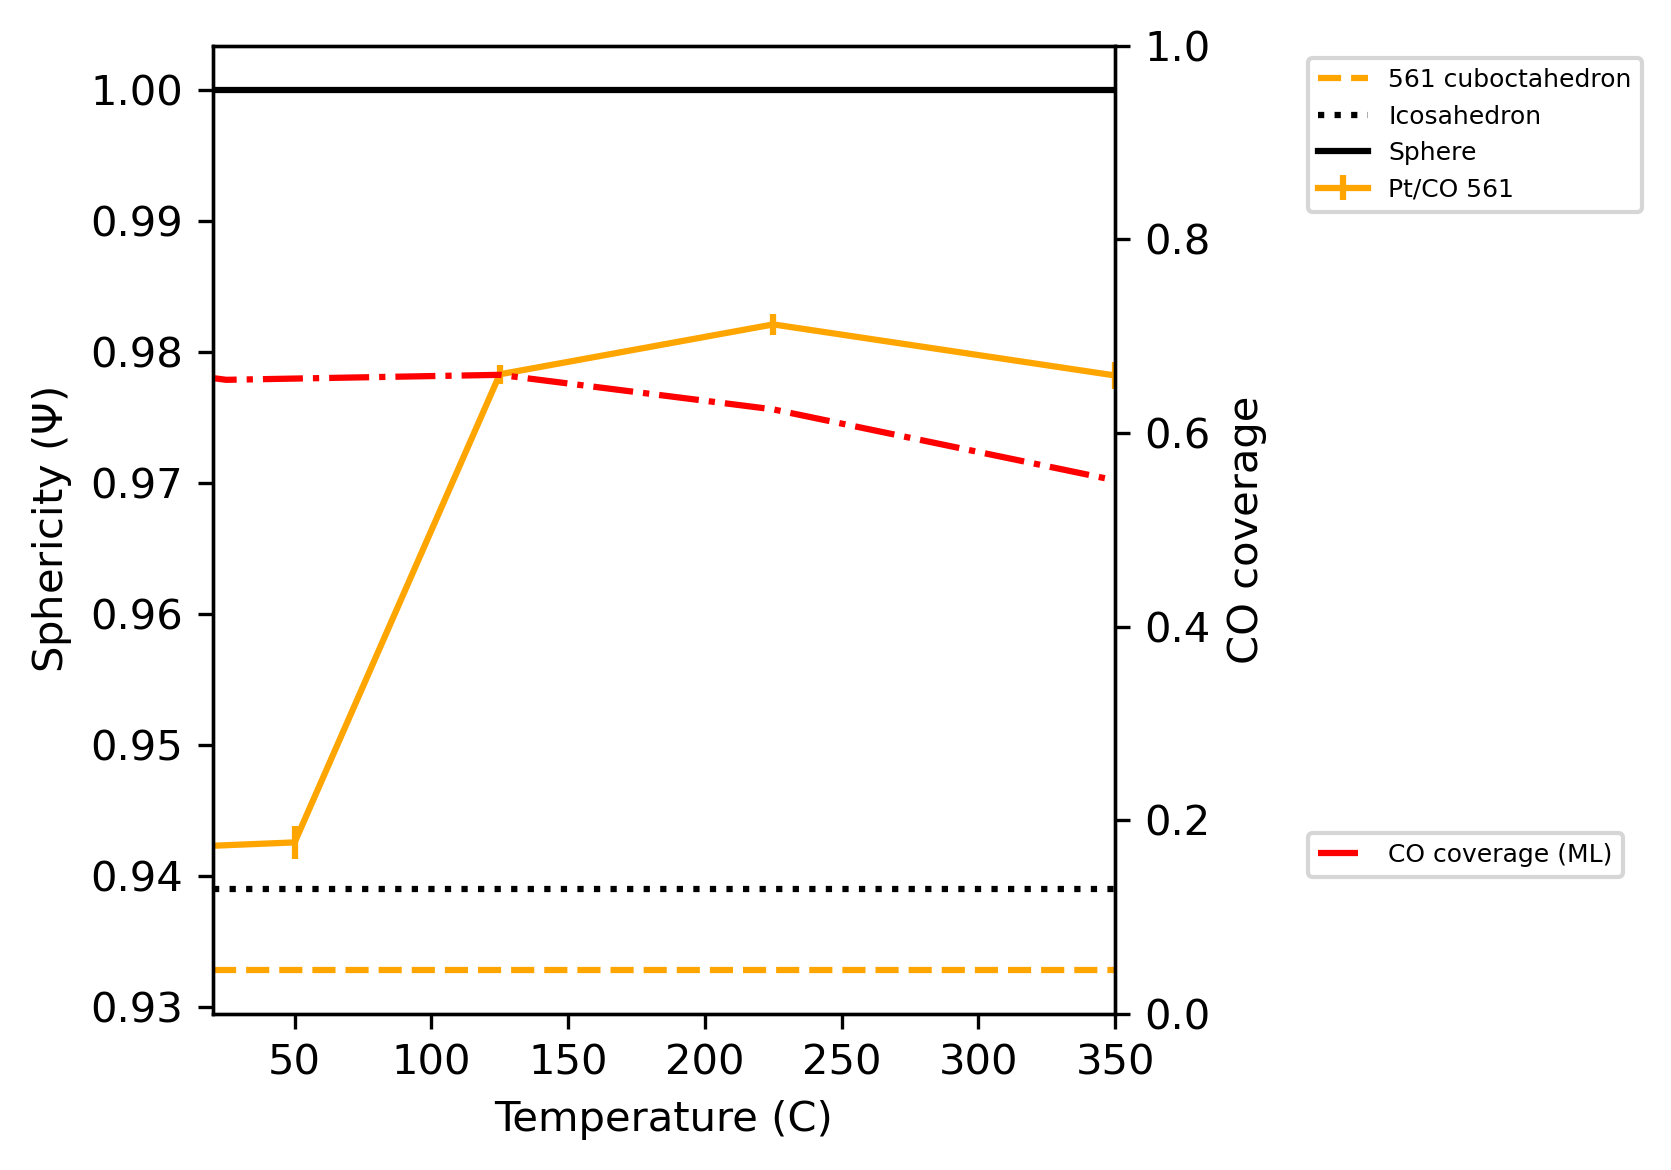

In [233]:
fig, ax1 = plt.subplots(1,1, figsize=(6, 4), dpi=300)

#ax1.errorbar(x = sphere_dict[561]["temps"], y=sphere_dict[561]["mean"], yerr=sphere_dict[561]["std"], label="Pt/CO 561", color= "blue")
ax1.errorbar(x = np.array(sphere_dict[561]["temps"])-273, y=sphere_dict[561]["mean"], yerr=sphere_dict[561]["std"], label="Pt/CO 561",  color= "orange")
#ax1.errorbar(x = sphere_dict[561]["temps"], y=sphere_dict[561]["mean"], yerr=sphere_dict[561]["std"], label="Pt/CO 561",  color= "green")
#ax1.axhline(y=benchmark_sphericity[561], label="561 cuboctahedron", linestyle='--', color='blue')
ax1.axhline(y=benchmark_sphericity[561], label="561 cuboctahedron",linestyle='--', color='orange')
#ax1.axhline(y=benchmark_sphericity[561], label="561 cuboctahedron", linestyle='--', color='green')
#ax1.axhline(y=[.9857], label="Disdyakis triacontahedron", linestyle='--', color='black')
#ax1.axhline(y=[.9609], label="Rhombic triacontahedron", linestyle='dashdot', color='black')
ax1.axhline(y=[.939], label="Icosahedron", linestyle=':', color='black')
ax1.axhline(y=[1], label="Sphere", linestyle='-', color='black')
ax1.set_xlabel("Temperature (C)")
ax1.set_ylabel("Sphericity ($\Psi$)")
ax1.legend(loc='upper left', bbox_to_anchor=(1.2, 1), fontsize=6)

ax3 = ax1.twinx()
ax3.plot(temperatures, totals/surface_pt, linestyle='dashdot',label= "CO coverage (ML)", color='red')
ax3.set_ylabel("CO coverage")
ax3.legend(loc='upper left', bbox_to_anchor=(1.2, 0.2), fontsize=6)
ax3.set_ylim(0, 1)
ax1.set_xlim(20, 350)




plt.tight_layout()
plt.show()

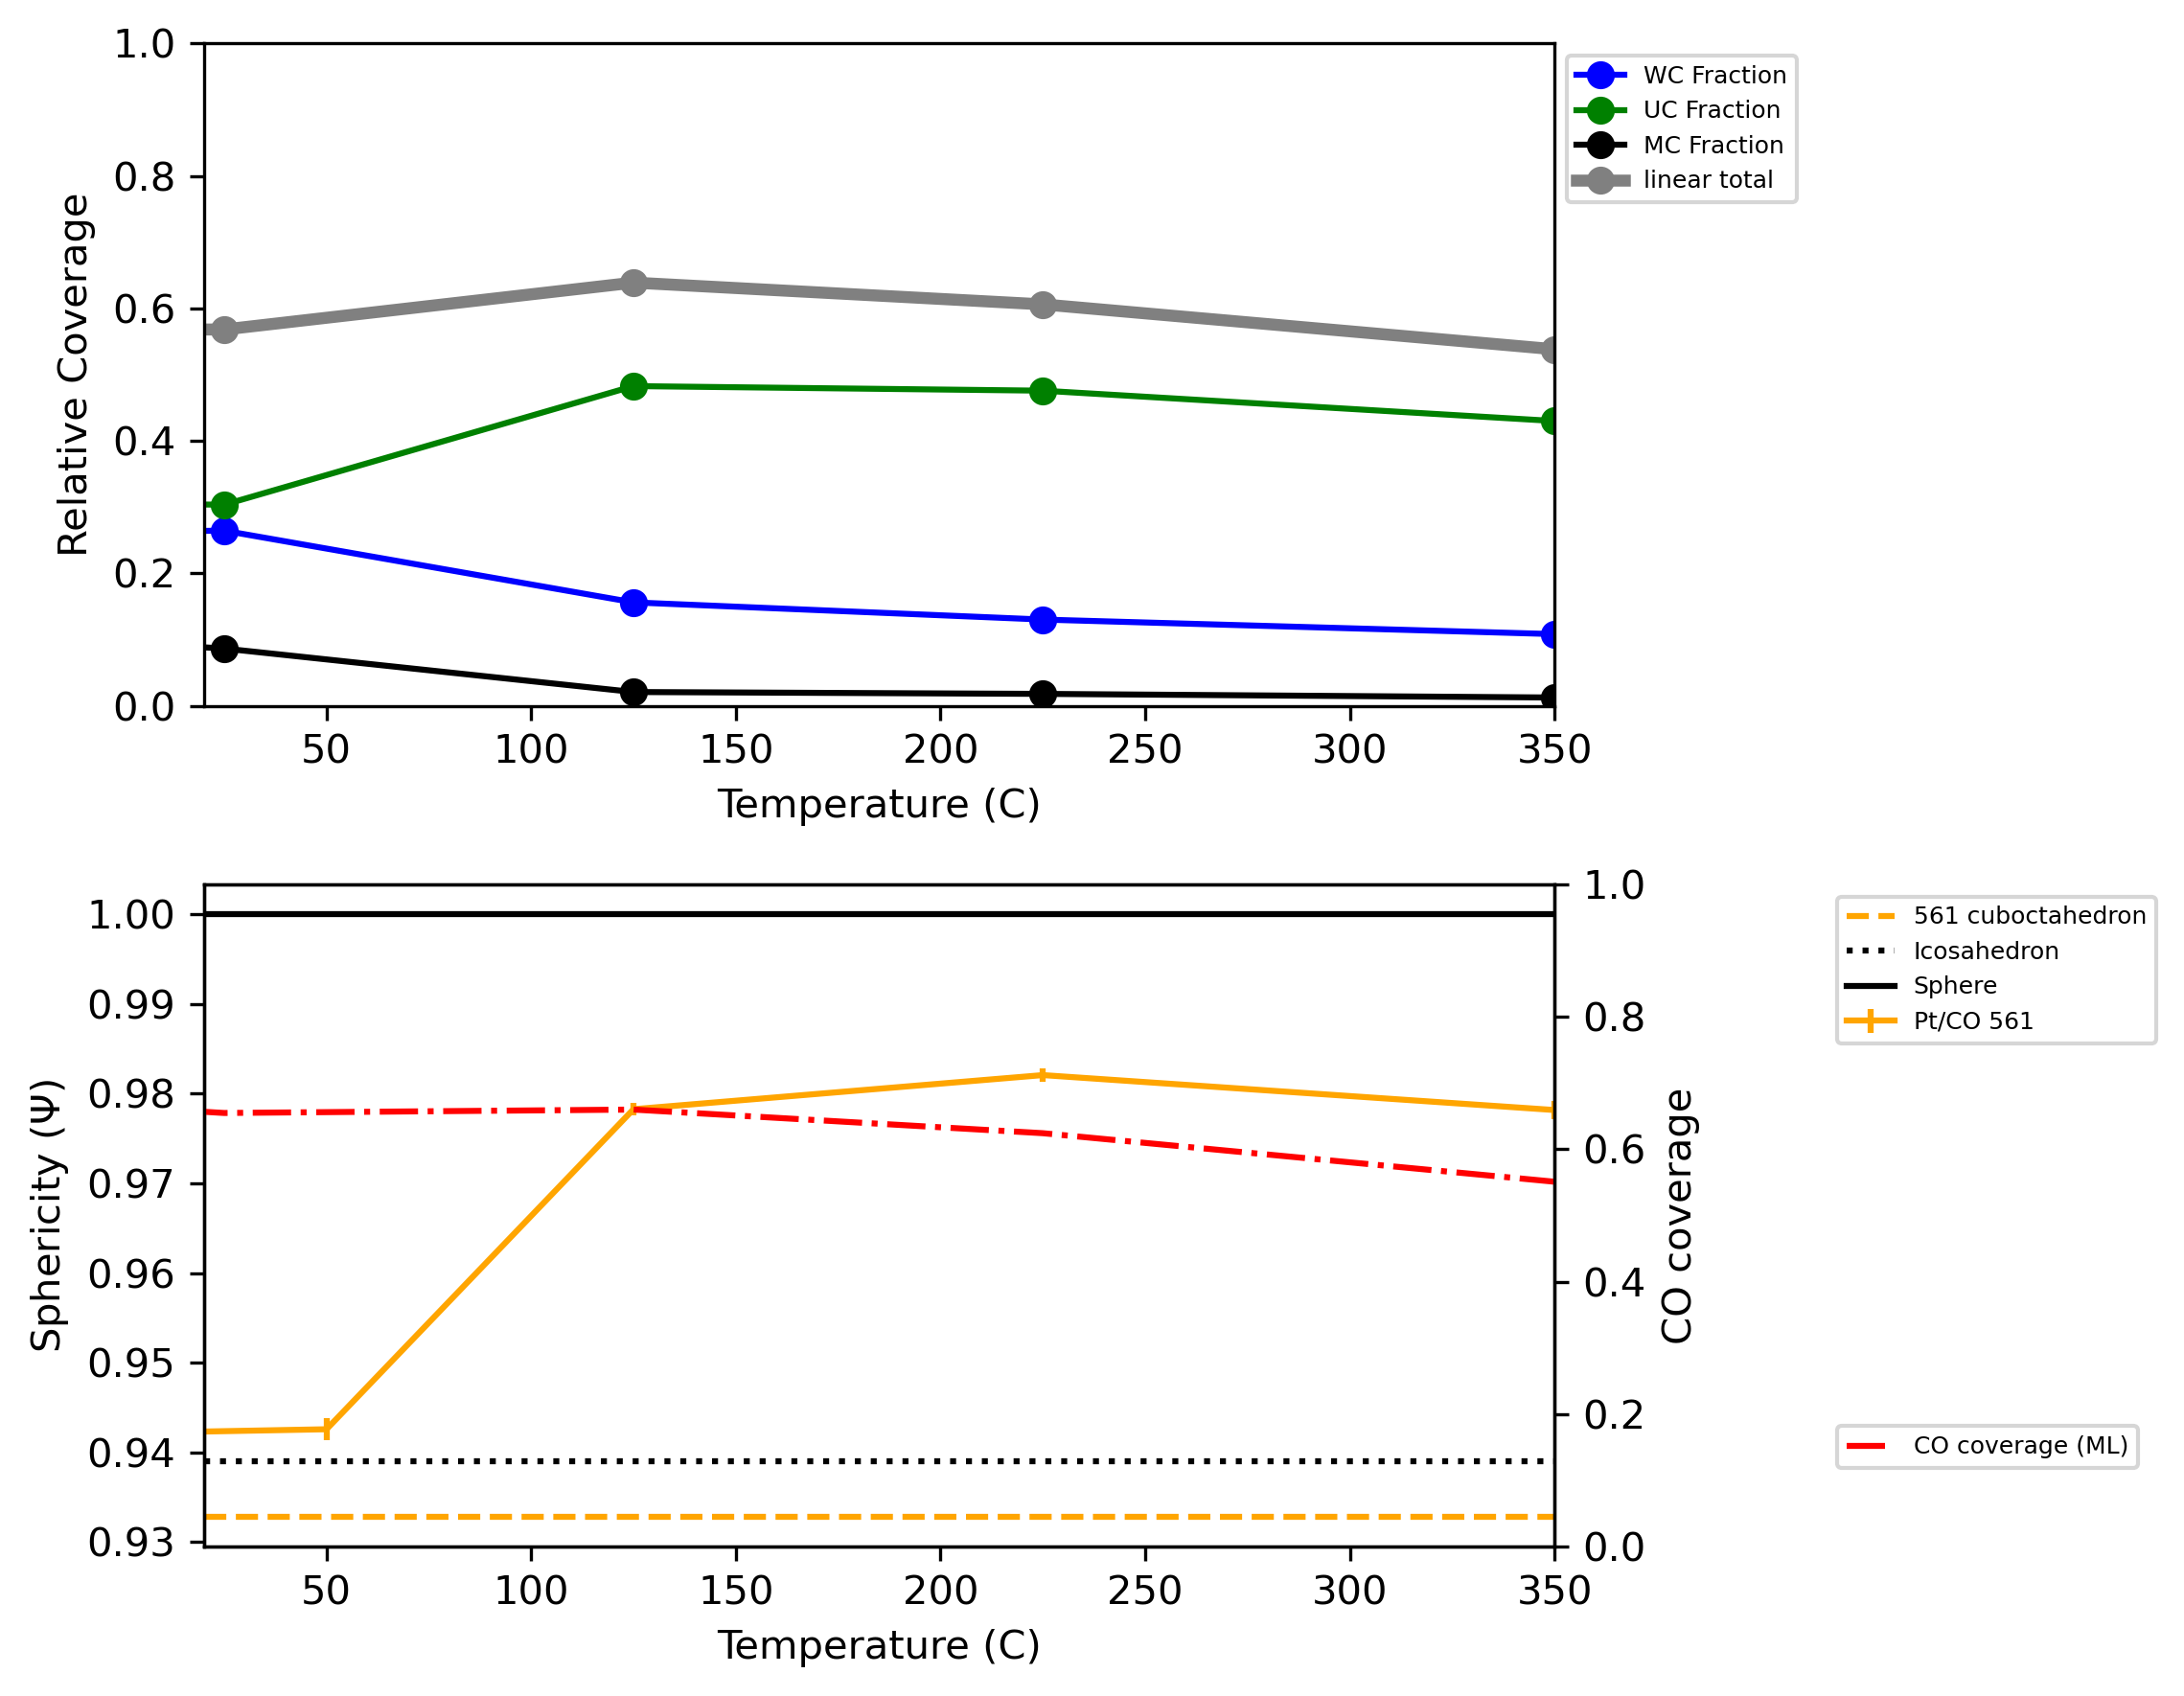

In [240]:
data_names = ["148K_5","173K_7", "198K_7", "223K_7", "273K_7", "298K_6", "398K_6", "498K_6", "623K_6"]
bond_lengths_561 = {}
asp = {}
for i in data_names:
    n_WC, n_UC, n_multi, r_WC, r_UC, r_multi = bond_lengths_WCUCMC(cluster_dict_561[i])
    bond_lengths_561[i] = {"n_WC": n_WC, "n_UC": n_UC, "n_multi": n_multi, "r_WC": r_WC, "r_UC": r_UC, "r_multi": r_multi}
    asp[i] = average_surface_pt(cluster_dict_561[i])

surface_pt = np.array([*asp.values()], dtype=object)

fig, ax1 = plt.subplots(2,1, figsize=(8, 6), dpi=300)

# Aggregate data for plotting
temperatures = np.array([int(i.split("K")[0]) for i in data_names]) - 273
totals = np.array([bond_lengths_561[i]["n_WC"] + bond_lengths_561[i]["n_UC"] + bond_lengths_561[i]["n_multi"] for i in data_names])
n_WC = np.array([bond_lengths_561[i]["n_WC"] / total for i, total in zip(data_names, totals)])
n_UC = np.array([bond_lengths_561[i]["n_UC"] / total for i, total in zip(data_names, totals)])
n_multi = np.array([bond_lengths_561[i]["n_multi"] / total for i, total in zip(data_names, totals)])

# Plotting fractions on primary y-axis
ax1[0].plot(temperatures, n_WC*(totals/surface_pt), label="WC Fraction", marker='o', color='b')
ax1[0].plot(temperatures, n_UC*(totals/surface_pt), label="UC Fraction", marker='o', color='g')
# normalized absorbance
ax1[0].plot(temperatures, n_multi*(totals/surface_pt), label="MC Fraction", marker='o', color='black')
ax1[0].plot(temperatures, (n_WC+n_UC)*(totals/surface_pt), lw = 3 , marker='o', color='gray', label ='linear total')

ax1[0].set_xlabel("Temperature (C)")
ax1[0].set_ylabel("Relative Coverage")
ax1[0].set_xlim(20, 350)
ax1[0].set_ylim(0, 1)

# Secondary axis for bond lengths
#ax2 = ax1[0].twinx()
#r_WC = np.array([bond_lengths_561[i]["r_WC"] for i in data_names])
#r_UC = np.array([bond_lengths_561[i]["r_UC"] for i in data_names])
#r_multi = np.array([bond_lengths_561[i]["r_multi"] for i in data_names])
#ax2.plot(temperatures, r_WC, label="WC CO Bond Length", linestyle='--', color='b')
#ax2.plot(temperatures, r_UC, label="UC CO Bond Length", linestyle='--', color='g')
#ax2.plot(temperatures, r_multi, label="MC CO Bond Length", linestyle='--', color='black')
#ax2.set_ylabel("Bond Length (Å)")
#ax2.set_ylim(1.16, 1.2)

# Adding constant lines for f_WC_561 and f_UC_561
#ax1[0].axhline(y=f_WC_561, color='blue', linestyle='-', linewidth=2, label="WC Perfect Cubo561")
#ax1[0].axhline(y=f_UC_561, color='green', linestyle='-', linewidth=2, label="UC Perfect Cubo561")

#ax1[0].axhline(y=f_WC_561_ico, color='purple', linestyle='-', linewidth=2, label="WC Perfect ICO561")
#ax1[0].axhline(y=f_UC_561_ico, color='black', linestyle='-', linewidth=2, label="UC Perfect ICO561")

# Adjusting legend positioning for ax1
ax1[0].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=6)



# Adjusting legend positioning for ax2
#ax2.legend(loc='upper left', bbox_to_anchor=(1.25, 0.2), fontsize=6)



#ax1[1].errorbar(x = sphere_dict[561]["temps"], y=sphere_dict[561]["mean"], yerr=sphere_dict[561]["std"], label="Pt/CO 561", color= "blue")
ax1[1].errorbar(x = np.array(sphere_dict[561]["temps"])-273, y=sphere_dict[561]["mean"], yerr=sphere_dict[561]["std"], label="Pt/CO 561",  color= "orange")
#ax1[1].errorbar(x = sphere_dict[561]["temps"], y=sphere_dict[561]["mean"], yerr=sphere_dict[561]["std"], label="Pt/CO 561",  color= "green")
#ax1[1].axhline(y=benchmark_sphericity[561], label="561 cuboctahedron", linestyle='--', color='blue')
ax1[1].axhline(y=benchmark_sphericity[561], label="561 cuboctahedron",linestyle='--', color='orange')
#ax1[1].axhline(y=benchmark_sphericity[561], label="561 cuboctahedron", linestyle='--', color='green')
#ax1[1].axhline(y=[.9857], label="Disdyakis triacontahedron", linestyle='--', color='black')
#ax1[1].axhline(y=[.9609], label="Rhombic triacontahedron", linestyle='dashdot', color='black')
ax1[1].axhline(y=[.939], label="Icosahedron", linestyle=':', color='black')
ax1[1].axhline(y=[1], label="Sphere", linestyle='-', color='black')
ax1[1].set_xlabel("Temperature (C)")
ax1[1].set_ylabel("Sphericity ($\Psi$)")
ax1[1].legend(loc='upper left', bbox_to_anchor=(1.2, 1), fontsize=6)
ax1[1].set_xlim(20, 350)

ax3 = ax1[1].twinx()
ax3.plot(temperatures, totals/surface_pt, linestyle='dashdot',label= "CO coverage (ML)", color='red')
ax3.set_ylabel("CO coverage")
ax3.legend(loc='upper left', bbox_to_anchor=(1.2, 0.2), fontsize=6)
ax3.set_ylim(0, 1)



plt.tight_layout()
plt.show()

In [84]:
# def write_xyz(atoms, filename):
#     # Mapping from numbers to atom symbols for output
#     number_to_symbol = {1: "Pt", 2: "C", 3: "O"}
    
#     with open(filename, 'w') as file:
#         file.write(f"{len(atoms)}\n")
#         file.write("Atoms with added C and O\n")
#         for atom in atoms:
#             symbol = number_to_symbol.get(atom[-1], "Unknown")  # Convert number to symbol
#             file.write(f"{symbol} {atom[0]:.5f} {atom[1]:.5f} {atom[2]:.5f}\n")

In [102]:
# write_xyz(cluster_dict_561["498K_6"]["data"][-1], "check_561.xyz")